In [3]:
import subprocess
import os
import pandas as pd
import numpy as np
import holidays
import glob
from pathlib import Path

# Install necessary Python libraries locally (instead of using Colab's `!pip`)
subprocess.run(["pip", "install", "geopy"], check=True)
subprocess.run(["pip", "install", "pyjanitor"], check=True)
subprocess.run(["pip", "install", "scikit-learn"], check=True)
subprocess.run(["pip", "install", "shapely"], check=True)
subprocess.run(["pip", "install", "holidays"], check=True)


CompletedProcess(args=['pip', 'install', 'holidays'], returncode=0)

In [4]:
!pip install holidays

In [5]:
# inflation data - Bank of Canada

import pandas as pd
import os
import glob
import datetime
from pathlib import Path
import numpy as np
import holidays
import csv
# Define the raw GitHub URL for the CSV file
github_url = "https://raw.githubusercontent.com/HICC-LICC/PSDC-Data-Challenge/main/adjusted_inflation.csv"

# Load the inflation data CSV from GitHub
df_inflca = pd.read_csv(github_url)

# Rename columns for better readability
df_inflca.rename(columns={
    "REF_DATE": "date",
    "VALUE": "adjusted national inflation rate",
    "Alternative measures": "measure"
}, inplace=True)

# Convert 'date' column to datetime format
df_inflca['date'] = pd.to_datetime(df_inflca['date'])

# Filter data for dates after 2014
df_inflca = df_inflca[df_inflca['date'].dt.year > 2014]

# Filter based on UOM_ID if the column exists
if 'UOM_ID' in df_inflca.columns:
    df_inflca = df_inflca[df_inflca['UOM_ID'] == 435]

# Filter for a specific inflation measure if the column exists
if 'measure' in df_inflca.columns:
    df_inflca = df_inflca[df_inflca['measure'] == "Measure of core inflation based on a weighted median approach, CPI-median (index, 198901=100)"]

# Keep only the relevant columns
df_inflca = df_inflca[['date', 'adjusted national inflation rate']]

# Display the cleaned DataFrame
print(df_inflca)


           date  adjusted national inflation rate
7755 2015-01-01                             166.8
7766 2015-02-01                             167.0
7777 2015-03-01                             167.3
7788 2015-04-01                             167.4
7799 2015-05-01                             167.8
...         ...                               ...
8965 2024-03-01                             210.1
8976 2024-04-01                             210.4
8987 2024-05-01                             211.0
8998 2024-06-01                             211.6
9009 2024-07-01                             211.8

[115 rows x 2 columns]


In [6]:
# inflation data - statcan

import pandas as pd
import os
import glob
import datetime
from pathlib import Path
import numpy as np
import holidays
import csv

# Define the direct GitHub release download URL for the file
github_url = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/unadjusted_inflation.csv"

# Load the inflation data directly from the GitHub release URL
df_infl = pd.read_csv(github_url)

df_infl['REF_DATE'] = pd.to_datetime(df_infl['REF_DATE'])
df_infl = df_infl[df_infl['REF_DATE'].dt.year > 2014]
df_infl = df_infl[df_infl.UOM_ID == 17]
df_infl = df_infl[df_infl['Products and product groups'].isin(['All-items', 'Shelter'])]

df_infl.rename(columns={
  "GEO": "CMA",
  "REF_DATE": "date",
  "Products and product groups": "product",
  "VALUE": "inflation rate",
}, inplace=True)

df_infl["CMA"].replace({
  'Canada': "CA",
  'Newfoundland and Labrador': "NL",
  "St. John's, Newfoundland and Labrador": "St. John's",
  'Prince Edward Island': "PE",
  'Charlottetown and Summerside, Prince Edward Island': "Charlottetown",
  'Nova Scotia': "NS",
  'Halifax, Nova Scotia': "Halifax",
  'New Brunswick': "NB",
  'Saint John, New Brunswick': "Saint John",
  'Quebec': "QC",
  'Québec, Quebec': "Quebec",
  'Montréal, Quebec': "Montreal",
  'Ontario': "ON",
  'Ottawa-Gatineau, Ontario part, Ontario/Quebec': "Ottawa",
  'Toronto, Ontario': "Toronto",
  'Thunder Bay, Ontario': "Thunder Bay",
  'Manitoba': "MB",
  'Winnipeg, Manitoba': "Winnipeg",
  'Saskatchewan': "SK",
  'Regina, Saskatchewan': "Regina",
  'Saskatoon, Saskatchewan': "Saskatoon",
  'Alberta': "AB",
  'Edmonton, Alberta': "Edmonton",
  'Calgary, Alberta': "Calgary",
  'British Columbia': "BC",
  'Vancouver, British Columbia': "Vancouver",
  'Victoria, British Columbia': "Victoria",
  'Whitehorse, Yukon': "Whitehorse",
  'Yellowknife, Northwest Territories': "Yellowknife",
  'Iqaluit, Nunavut': "Iqualuit"
}, inplace=True)

df_infl = df_infl[
  ['date',
  'CMA',
  'product',
  'inflation rate'
  ]]

df_infl = df_infl.pivot_table('inflation rate', ['date', 'CMA'], 'product')
df_infl = df_infl.reset_index()

df_infl.rename(columns={
  "All-items": "inflation_all",
  "Shelter": "inflation_shelter",
}, inplace=True)

df_infl


C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\881293538.py:16: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_infl = pd.read_csv(github_url)


product,date,CMA,inflation_all,inflation_shelter
0,2015-01-01,AB,131.0,163.9
1,2015-01-01,BC,118.0,114.0
2,2015-01-01,CA,124.3,133.1
3,2015-01-01,Calgary,131.7,164.3
4,2015-01-01,Charlottetown,126.3,128.5
...,...,...,...,...
3445,2024-07-01,Vancouver,159.1,167.2
3446,2024-07-01,Victoria,152.9,152.2
3447,2024-07-01,Whitehorse,160.6,211.4
3448,2024-07-01,Winnipeg,162.0,191.5


In [7]:
# employment data

import pandas as pd
import requests
import io

# Clean employment data

# Define the URL to the release download file
github_url = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/adjusted_employment.csv"

# Download the CSV file from the GitHub release URL
response = requests.get(github_url)

# Load the content directly into a pandas DataFrame
df_empl = pd.read_csv(io.StringIO(response.text))

df_empl['REF_DATE'] = pd.to_datetime(df_empl['REF_DATE'])
df_empl = df_empl[df_empl['REF_DATE'].dt.year > 2014]
df_empl = df_empl[df_empl['Labour force characteristics'].isin(['Unemployment rate'])]
df_empl = df_empl[df_empl['Statistics'].isin(['Estimate'])]
df_empl = df_empl[df_empl['Data type'].isin(['Seasonally adjusted'])]

df_empl.rename(columns={
  "GEO": "province",
  "REF_DATE": "date",
  "VALUE": "unemployment rate"
}, inplace=True)

df_empl["province"].replace({
  'Canada': "CA",
  'Newfoundland and Labrador': "NL",
  'Prince Edward Island': "PE",
  'Nova Scotia': "NS",
  'New Brunswick': "NB",
  'Quebec': "QC",
  'Ontario': "ON",
  'Manitoba': "MB",
  'Saskatchewan': "SK",
  'Alberta': "AB",
  'British Columbia': "BC",
}, inplace=True)

df_empl = df_empl[
  ['date',
  'province',
  'unemployment rate'
  ]]

df_empl

C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\3546807711.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_empl = pd.read_csv(io.StringIO(response.text))


,date,province,unemployment rate
162833,2015-01-01,CA,6.7
162865,2015-01-01,NL,11.9
162897,2015-01-01,"St. John's, Newfoundland and Labrador",6.0
162929,2015-01-01,PE,10.8
162961,2015-01-01,NS,8.6
...,...,...,...
339313,2024-07-01,BC,5.4
339345,2024-07-01,"Kelowna, British Columbia",4.4
339377,2024-07-01,"Abbotsford-Mission, British Columbia",6.3
339409,2024-07-01,"Vancouver, British Columbia",5.8


In [8]:
# employment data

import pandas as pd
import requests
import io

# Clean employment data

# Define the URL to the release download file
github_url = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/unadjusted_employment.csv"

# Download the CSV file from the GitHub release URL
response = requests.get(github_url)

# Load the content directly into a pandas DataFrame
df_empl = pd.read_csv(io.StringIO(response.text))

df_empl['REF_DATE'] = pd.to_datetime(df_empl['REF_DATE'])
df_empl = df_empl[df_empl['REF_DATE'].dt.year > 2014]
df_empl = df_empl[df_empl['Labour force characteristics'].isin(['Unemployment rate'])]
df_empl = df_empl[df_empl['Sex'].isin(['Both sexes'])]
df_empl = df_empl[df_empl['Age group'].isin(['15 years and over'])]
df_empl = df_empl[df_empl['Population centre and rural areas'].isin(['Census metropolitan area and census agglomeration'])]

df_empl.rename(columns={
  "GEO": "province",
  "REF_DATE": "date",
  "VALUE": "unemployment rate"
}, inplace=True)

df_empl["province"].replace({
  'Canada': "CA",
  'Newfoundland and Labrador': "NL",
  'Prince Edward Island': "PE",
  'Nova Scotia': "NS",
  'New Brunswick': "NB",
  'Quebec': "QC",
  'Ontario': "ON",
  'Manitoba': "MB",
  'Saskatchewan': "SK",
  'Alberta': "AB",
  'British Columbia': "BC",
}, inplace=True)

df_empl = df_empl[
  ['date',
  'province',
  'unemployment rate'
  ]]

df_empl

,date,province,unemployment rate
1142019,2015-01-01,CA,6.9
1144179,2015-01-01,NL,7.9
1146339,2015-01-01,PE,10.5
1148499,2015-01-01,NS,8.6
1150659,2015-01-01,NB,8.5
...,...,...,...
3863619,2024-07-01,ON,7.7
3865779,2024-07-01,MB,6.8
3867939,2024-07-01,SK,6.2
3870099,2024-07-01,AB,7.5


In [9]:
# Clean Alberta Data

import pandas as pd
import requests
import io

# Define the direct GitHub release download link
github_url = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/shelter_alberta.xlsx"

# Download the Excel file from GitHub
response = requests.get(github_url)

# Load the content directly into a pandas DataFrame
df = pd.read_excel(io.BytesIO(response.content), engine='openpyxl')

# Display the first few rows of the dataframe
df.head()



,date,city,ShelterType,ShelterName,Organization,Shelter,Capacity,Overnight,Daytime,year,month
0,4/1/2013,Edmonton,Women Emergency,WEAC,WEAC,NaN,75.0,65.0,NaN,2013,4
1,4/1/2013,Edmonton,Intox,Hope Mission - Intox Centre,Hope Mission,Intox Centre,70.0,74.0,NaN,2013,4
2,4/1/2013,Edmonton,Adult Emergency,Hope Mission - Herb Jamieson Centre,Hope Mission,Herb Jamieson Centre,250.0,253.0,NaN,2013,4
3,4/1/2013,Edmonton,Winter Emergency,Hope Mission - Mat Emergency Shelter Program,Hope Mission,Mat Emergency Shelter Program,200.0,152.0,NaN,2013,4
4,4/1/2013,Edmonton,Youth Emergency,Hope Mission - Youth,Hope Mission,Youth,60.0,51.0,NaN,2013,4


In [10]:
#alberta
df_alberta = df

#find day of the week
df_alberta['date'] = pd.to_datetime(df['date'])
df_alberta["day_week"] = df_alberta["date"].dt.dayofweek
df_alberta["day_week"].replace({
    0 : '1-mon',
    1 : '2-tue',
    2 : '3-wed',
    3 : '4-thu',
    4 : '5-fri',
    5 : '6-sat',
    6 : '7-sun',
}, inplace=True)

#find month
df_alberta["month"].replace({
    1 : '01-jan',
    2 : '02-feb',
    3 : '03-mar',
    4 : '04-apr',
    5 : '05-may',
    6 : '06-jun',
    7 : '07-jul',
    8 : '08-aug',
    9 : '09-sep',
    10 : '10-oct',
    11 : '11-nov',
    12 : '12-dec'
}, inplace=True)

#find last week of the month
df_alberta['Date_Month_End'] = df_alberta['date'] + pd.offsets.MonthEnd(n=0)
df_alberta['Date_Month_End'] = df_alberta["Date_Month_End"].dt.day
df_alberta['day_month'] = df_alberta["date"].dt.day
df_alberta['last_week'] = np.where((df_alberta["Date_Month_End"] - df_alberta['day_month'])  < 8, 1, 0)

#find first week of the month
df_alberta['first_week'] = np.where(df_alberta['day_month']  < 8, 1, 0)


#find provincial holidays
#df_alberta['hols'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('CAN',prov='ON').get(x)).values

#df_alberta['hols_bi'] = df_alberta['hols']
#df_alberta['hols_bi'] = np.where(df_alberta['hols'] == "", 0, 1)

#remove closed shelters
df_alberta.loc[df_alberta['Capacity'] == 0,'Capacity'] = np.nan
df_alberta['occupancy_rate'] = df_alberta['Overnight'] / df_alberta['Capacity']

df_alberta = df_alberta[
  ['date',
  'city',
  'ShelterType',
  'ShelterName',
  'Organization',
  'Capacity',
  'Overnight',
  'year',
  'month',
  'occupancy_rate',
  'day_week',
  'last_week',
  'first_week'
  ]]

df_alberta['date'] = df_alberta['date'].astype('datetime64[ns]')

df_alberta


C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\3477750829.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alberta['date'] = df_alberta['date'].astype('datetime64[ns]')


,date,city,ShelterType,ShelterName,Organization,Capacity,Overnight,year,month,occupancy_rate,day_week,last_week,first_week
0,2013-04-01,Edmonton,Women Emergency,WEAC,WEAC,75.0,65.0,2013,04-apr,0.866667,1-mon,0,1
1,2013-04-01,Edmonton,Intox,Hope Mission - Intox Centre,Hope Mission,70.0,74.0,2013,04-apr,1.057143,1-mon,0,1
2,2013-04-01,Edmonton,Adult Emergency,Hope Mission - Herb Jamieson Centre,Hope Mission,250.0,253.0,2013,04-apr,1.012000,1-mon,0,1
3,2013-04-01,Edmonton,Winter Emergency,Hope Mission - Mat Emergency Shelter Program,Hope Mission,200.0,152.0,2013,04-apr,0.760000,1-mon,0,1
4,2013-04-01,Edmonton,Youth Emergency,Hope Mission - Youth,Hope Mission,60.0,51.0,2013,04-apr,0.850000,1-mon,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271536,2024-07-31,Edmonton,Adult Emergency,Navigation & Support Centre,Hope Mission,20.0,3.0,2024,07-jul,0.150000,3-wed,1,0
271537,2024-07-31,Edmonton,Winter Emergency,Pimatisiwin Trailers,Niginan Housing Ventures,NaN,0.0,2024,07-jul,NaN,3-wed,1,0
271538,2024-07-31,Edmonton,Adult Emergency,Maskokamik Shelter,Enoch Cree Nation,100.0,40.0,2024,07-jul,0.400000,3-wed,1,0
271539,2024-07-31,Edmonton,Adult Emergency,Karis Centre,Hope Mission,80.0,81.0,2024,07-jul,1.012500,3-wed,1,0


In [11]:
#merge weather files
import pandas as pd
import requests
from io import StringIO

# List of direct download URLs
urls = [
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Bow.Valley.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Bow.Valley.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Calgary.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Cold.Lake.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Cold.Lake.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Edmonton.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Edson.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Fort.McMurray.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Grande.Prairie.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Grande.Prairie.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Lac.La.Biche.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Lethbridge.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Lloyminster.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Medicine.Hat.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Peace.River.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Peace.River.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Red.Deer.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Red.Deer.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Red.Deer.3.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Slave.Lake.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Toronto.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Westaskiwin.csv"
]

# Create an empty list to store dataframes
flist = []

# Download and read each CSV file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        df_temp = pd.read_csv(StringIO(response.text))
        flist.append(df_temp)
    else:
        print(f"Failed to download: {url}")

# Concatenate all the dataframes into one
df_weather = pd.concat(flist, axis=0, ignore_index=True)

# Remove entries earlier than 2014
df_weather = df_weather[df_weather['LOCAL_YEAR'] >= 2014]

# Rename station names to city names
df_weather["STATION_NAME"].replace({
    'BOW VALLEY': 'Bow Valley',
    'CALGARY INTL A': 'Calgary',
    'COLD LAKE A': 'Cold Lake',
    'EDMONTON INTERNATIONAL CS': 'Edmonton',
    'EDSON': 'Edson',
    'FORT MCMURRAY A': 'Fort McMurray',
    'GRANDE PRAIRIE A': 'Grande Prairie',
    'LAC LA BICHE CLIMATE': 'Lac La Biche',
    'LETHBRIDGE': 'Lethbridge',
    'LLOYDMINSTER': 'Lloydminster',
    'MEDICINE HAT': 'Medicine Hat',
    'PEACE RIVER A': 'Peace River',
    'RED DEER A': 'Red Deer',
    'RED DEER REGIONAL A': 'Red Deer',
    'SLAVE LAKE': 'Slave Lake',
    'WETASKIWIN AGCM': 'Wetaskiwin',
}, inplace=True)

# Convert 'LOCAL_DATE' to datetime and keep only the date part
df_weather['LOCAL_DATE'] = pd.to_datetime(df_weather['LOCAL_DATE']).dt.date

# Sort data by station name and date
df_weather = df_weather.sort_values(by=['STATION_NAME', 'LOCAL_DATE'])

# Interpolate missing temperature data
df_weather['MIN_TEMPERATURE'] = df_weather['MIN_TEMPERATURE'].interpolate()
df_weather['MAX_TEMPERATURE'] = df_weather['MAX_TEMPERATURE'].interpolate()
df_weather['MEAN_TEMPERATURE'] = df_weather['MEAN_TEMPERATURE'].interpolate()

# Replace missing precipitation values with 0
df_weather.update(df_weather[['TOTAL_PRECIPITATION']].fillna(0))

# Keep relevant columns
df_weather = df_weather[
  ['STATION_NAME', 'MEAN_TEMPERATURE', 'TOTAL_PRECIPITATION', 'LOCAL_DATE',
   'MIN_TEMPERATURE', 'MAX_TEMPERATURE', 'PROVINCE_CODE', 'x', 'y']
]

# Rename columns for clarity
df_weather.rename(columns={
    "STATION_NAME": "city",
    "MEAN_TEMPERATURE": "mean_temperature",
    "TOTAL_PRECIPITATION": "total_precipitation",
    "LOCAL_DATE": "date",
    "MIN_TEMPERATURE": "min_temperature",
    "MAX_TEMPERATURE": "max_temperature",
    "PROVINCE_CODE": "province"
}, inplace=True)

# Ensure the 'date' column is in the correct datetime format
df_weather['date'] = pd.to_datetime(df_weather['date'])

# Display the cleaned dataframe
df_weather.head()




,city,mean_temperature,total_precipitation,date,min_temperature,max_temperature,province,x,y
7363,Bow Valley,-6.4,0.0,2014-01-01,-15.9,3.2,AB,-115.066667,51.083333
7364,Bow Valley,4.9,0.0,2014-01-02,2.2,7.6,AB,-115.066667,51.083333
7365,Bow Valley,-2.4,5.2,2014-01-03,-7.1,2.4,AB,-115.066667,51.083333
7366,Bow Valley,-17.6,4.1,2014-01-04,-28.1,-7.0,AB,-115.066667,51.083333
7367,Bow Valley,-22.6,0.0,2014-01-05,-34.6,-10.5,AB,-115.066667,51.083333


In [12]:
import os
import subprocess
import pandas as pd

# Load the census data directly from GitHub release URL
url = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/census.1.csv"
df_census = pd.read_csv(url, encoding='ISO-8859-1')

#keep only census
df_census["GEO_NAME"].replace({
    'Calgary, City (CY)' : 'Calgary',
    'Cold Lake, City (CY)' : 'Cold Lake',
    'Drayton Valley, Town (T)' : 'Drayton Valley',
    'Edmonton, City (CY)' : 'Edmonton',
    'Edson, Town (T)' : 'Edson',
    'Grande Prairie, City (CY)' : 'Grande Prairie',
    'Lac la Biche County, Specialized municipality (SM)' : 'Lac La Biche',
    'Leduc, City (CY)' : 'Leduc',
    'Lethbridge, City (CY)' : 'Lethbridge',
    'Lloydminster (Part), City (CY)' : 'Lloydminster',
    'Medicine Hat, City (CY)' : 'Medicine Hat',
    'Peace River, Town (T)' : 'Peace River',
    'Red Deer, City (CY)' : 'Red Deer',
    'Slave Lake, Town (T)' : 'Slave Lake',
    'Spring Lake, Village (VL)' : 'Spruce Grove',
    'Wetaskiwin, City (CY)' : 'Wetaskiwin'
}, inplace=True)

# Rest of your code remains exactly the same...

list_cities = df_alberta['city'].unique().tolist()
list_cities.sort()

df_census = df_census.loc[df_census["GEO_NAME"].isin(list_cities)]


list_characteristics = [1,3,4,5, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 252, 253, 360, 361, 363, 364, 379, 380, 381, 382, 1482, 1483, 1484, 1486, 1488, 1490, 1491, 1492, 1494, 1496, 1497, 1498, 1499, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1535, 1536, 1537, 1983, 1984, 1985, 1986, 1987, 1988, 1991, 2014, 2015, 2016, 2017, 2228, 2229, 2230, 2239, 2240, 2241, 2242, 2245]
df_census = df_census.loc[df_census["CHARACTERISTIC_ID"].isin(list_characteristics)]

#keep relevant columns
df_census = df_census[
  ['CENSUS_YEAR',
  'GEO_NAME',
   'CHARACTERISTIC_ID',
  'CHARACTERISTIC_NAME',
  'C1_COUNT_TOTAL'
  ]]

df_census.rename(columns={
    'CENSUS_YEAR' : 'year',
    'GEO_NAME' : 'city'
}, inplace =True )

#create pivot table
df_census = pd.pivot_table(df_census, values="C1_COUNT_TOTAL", index=["city"], columns=["CHARACTERISTIC_NAME"])\

df_census = df_census.reset_index()

#clean pivot table
df_census.rename(columns={
  '      2011 to 2015' : 'immigrant status - immigrants - 2011-2015',
  '      2016 to 2021' : 'immigrant status - immigrants - 2016-202l',
  '      External migrants' : 'migrant 5 years - movers - migrants - external',
  '      Internal migrants' : 'migrant 5 years - movers - migrants - internal',
  '      Permanent position' : 'workers - empoyee - permanent',
  '      Temporary position' : 'workers - employee - temporary',
  '    1980 to 1990' : 'immigrant status - immigrants - 1980-1990',
  '    1991 to 2000' : 'immigrant status - immigrants - 1991-2000',
  '    2001 to 2010' : 'immigrant status - immigrants - 2001-2010',
  '    Before 1980' : 'immigrant status - immigrants - before 1980',
  '    Employee' : 'workers - employee - total',
  '    Migrants' : 'migrants 5 years - movers - migrants - total',
  '    Non-migrants' : 'migrants 5 years - movers - non-migrants',
  '    Self-employed' : 'workers - self-employed',
  '  % of owner households spending 30% or more of its income on shelter costs' : 'dwelling owners (%) - spending over 30% in shelter',
  '  % of owner households with a mortgage' : 'dwelling owners (%) - with mortgage',
  '  % of tenant households in subsidized housing' : 'dwelling tenants (%) - in subsidized housing',
  '  % of households living in a dwelling provided by the local government, First Nation or Indian band spending more than 30% on shelter costs' : 'dwelling government (%) - spending over 30% in shelter',
  '  % of tenant households spending 30% or more of its income on shelter costs' : 'dwelling tenants (%) - spending over 30% in shelter',
  '  0 to 14 years' : 'age group (%) - 0-14 years',
  '  0 to 17 years (%)' : 'LICO-AT (%) - 0-17 years',
  '  1 person' : 'household size - 1 person',
  '  15 to 64 years' : 'age group (%) - 15-64 years',
  '  18 to 64 years (%)' : 'LICO-AT (%) - 18-64 years',
  '  2 persons' : 'household size - 2 persons',
  '  3 persons' : 'household size - 3 persons',
  '  4 persons' : 'household size - 4 persons',
  '  5 or more persons' : 'household size - 5 or more persons',
  '  65 years and over' : 'age group (%) - 65+ years',
  '  65 years and over (%)' : 'LICO-AT (%) - 65+ years',
  '  All classes of workers' : 'workers - total',
  '  Apartment in a building that has fewer than five storeys' : 'type of dwelling - apartment in a building that has fewer than five storeys',
  '  Apartment in a building that has five or more storeys' : 'type of dwelling - apartment in a building that has five or more storeys',
  '  Apartment or flat in a duplex' : 'type of dwelling - apartment or flat in a duplex',
  '  Apartment or flat in a multi-family building' : 'type of dwelling - apartment or flat in a multi-family building',
  '  Median after-tax income of household in 2020 ($)' : 'after-tax income of household ($) - average',
  '  Average after-tax income of household in 2020 ($)' : 'after-tax income of household ($) - average',
  '  Average total income of household in 2020 ($)' : 'total income of household ($) - average',
  '  Median total income of household in 2020 ($)' : 'total income of household ($) - median',
  '  Gini index on adjusted household after-tax income' : 'Gini index - adjusted household after-tax income',
  '  Gini index on adjusted household market income' : 'Gini index - adjusted household market income',
  '  Gini index on adjusted household total income' : 'Gini index - adjusted household total income',
  '  High (secondary) school diploma or equivalency certificate' : "education - high school or equivalent",
  '  Immigrants' : 'immigrant status - immigrants - total',
  '  Median monthly shelter costs for owned dwellings ($)' : 'dwelling owners ($) - median shelter costs',
  '  Median monthly shelter costs for rented dwellings ($)' : 'dwelling tenants ($) - median shelter costs',
  '  Median monthly shelter costs for dwellings provided by local government, First Nation or Indian band ($)' : 'dwelling government - median shelter costs',
  '  Median value of dwellings ($)' : 'dwelling owners ($) - median value of dwelling',
  '  Movable dwelling' : 'type of dwelling - moving dwelling',
  '  Movers' : 'migrant 5 years - movers - total',
  '  No certificate, diploma or degree' : "education - no certificate",
  '  Non-immigrants' : 'immigrant status - non-immigrants',
  '  Non-movers' : 'migrant 5 years - non-movers',
  '  Non-permanent residents' : 'immigrant status - non-permanant residents',
  '  Other single-attached house' : 'type of dwelling - other single-attached house',
  '  P90/P10 ratio on adjusted household after-tax income' : 'P90/P10 - adjusted household after-tax income',
  '  Postsecondary certificate, diploma or degree' : "education - post secondary",
  '  Row house' : 'type of dwelling - rowhouse',
  '  Semi-detached house' : 'type of dwelling - semi-detached house',
  '  Single-detached house' : 'type of dwelling - single-detached house',
  'Average household size' : 'household size - average',
  'Employment rate' : 'labor force (%) - employment rate',
  'Median age of the population' : 'age group - median age',
  'Participation rate' : 'labor force (%) - participation rate',
  'Population percentage change, 2016 to 2021' : 'population - change from 2016-2021',
  'Population, 2021' : 'population - number',
  'Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)' : "LICO-AT (%) - All",
  'Private dwellings occupied by usual residents' : 'private dwelling - user occupied',
  'Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data' : "education - total",
  'Total - Households living in a dwelling provided by the local government, First Nation or Indian band in non-farm private dwellings - 25% sample data' : 'dwelling government - total',
  'Total - Immigrant status and period of immigration for the population in private households - 25% sample data' : 'immigrant status - total',
  'Total - Mobility status 5 years ago - 25% sample data' : 'migrant 5 years - total',
  'Total - Occupied private dwellings by structural type of dwelling - 100% data' : 'type of dwelling - total',
  'Total - Owner households in non-farm, non-reserve private dwellings - 25% sample data' : 'dwelling owners - total',
  'Total - Private households by household size - 100% data' : 'household size - total',
  'Total - Tenant households in non-farm, non-reserve private dwellings - 25% sample data' : 'dwelling tenants - total',
  'Total private dwellings' : 'private dwelling - total',
  'Unemployment rate' : 'labor force (%) - unemployment rate',
  'GEO_NAME	' : 'city'
}, inplace =True )

#Make sure sums are correct
type_of_dwelling = [
  'type of dwelling - apartment in a building that has fewer than five storeys',
  'type of dwelling - apartment in a building that has five or more storeys',
  'type of dwelling - apartment or flat in a duplex',
  'type of dwelling - moving dwelling',
  'type of dwelling - other single-attached house',
  'type of dwelling - rowhouse',
  'type of dwelling - semi-detached house',
  'type of dwelling - single-detached house'
  ]

df_census['type of dwelling - total'] = df_census[type_of_dwelling].sum(axis=1)

df_census[type_of_dwelling] = (df_census[type_of_dwelling].div(df_census['type of dwelling - total'], axis=0)*100).apply(lambda x: round(x, 1))


##

household_size = [
 'household size - 1 person',
 'household size - 2 persons',
 'household size - 3 persons',
 'household size - 4 persons',
 'household size - 5 or more persons'
]

df_census['household size - total'] = df_census[household_size].sum(axis=1)

df_census[household_size] = (df_census[household_size].div(df_census['household size - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

immigrant_status_1 = [
 'immigrant status - immigrants - 1980-1990',
 'immigrant status - immigrants - 1991-2000',
 'immigrant status - immigrants - 2001-2010',
 'immigrant status - immigrants - 2011-2015',
 'immigrant status - immigrants - 2016-202l',
 'immigrant status - immigrants - before 1980'
]

df_census['immigrant status - immigrants - total'] = df_census[immigrant_status_1].sum(axis=1)

immigrant_status_2 = [
 'immigrant status - immigrants - total',
 'immigrant status - non-permanant residents',
 'immigrant status - non-immigrants',
]

df_census['immigrant status - total'] = df_census[immigrant_status_2].sum(axis=1)

immigrant_status_3 = [
 'immigrant status - immigrants - 1980-1990',
 'immigrant status - immigrants - 1991-2000',
 'immigrant status - immigrants - 2001-2010',
 'immigrant status - immigrants - 2011-2015',
 'immigrant status - immigrants - 2016-202l',
 'immigrant status - immigrants - before 1980',
 'immigrant status - non-permanant residents',
 'immigrant status - non-immigrants'
]

df_census[immigrant_status_3] = (df_census[immigrant_status_3].div(df_census['immigrant status - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

migrants_1 = [
 'migrant 5 years - movers - migrants - external',
 'migrant 5 years - movers - migrants - internal'
]

df_census['migrants 5 years - movers - migrants - total'] = df_census[migrants_1].sum(axis=1)


migrants_2 = [
 'migrants 5 years - movers - migrants - total',
 'migrants 5 years - movers - non-migrants'
]

df_census['migrant 5 years - movers - total'] = df_census[migrants_2].sum(axis=1)

migrants_3 = [
 'migrant 5 years - non-movers',
 'migrant 5 years - movers - total'
]

migrants_4 = [
 'migrant 5 years - movers - migrants - external',
 'migrant 5 years - movers - migrants - internal',
 'migrants 5 years - movers - non-migrants',
 'migrant 5 years - non-movers'
]

df_census['migrant 5 years - total'] = df_census[migrants_3].sum(axis=1)

df_census[migrants_4] = (df_census[migrants_4].div(df_census['migrant 5 years - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

education = [
 'education - high school or equivalent',
 'education - no certificate',
 'education - post secondary'
]

df_census['education - total'] = df_census[education].sum(axis=1)

df_census[education] = (df_census[education].div(df_census['education - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

workers_1 = [
 'workers - employee - temporary',
 'workers - empoyee - permanent'
]

df_census['workers - employee - total'] = df_census[workers_1].sum(axis=1)

workers_2 = [
 'workers - self-employed',
 'workers - employee - total'
]

df_census['workers - total'] = df_census[workers_2].sum(axis=1)

workers_3 = [
 'workers - employee - temporary',
 'workers - empoyee - permanent',
 'workers - self-employed'
]

df_census[workers_3] = (df_census[workers_3].div(df_census['workers - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

ownership = [
 'dwelling government - total',
 'dwelling owners - total',
 'dwelling tenants - total'
]

df_census['dwelling ownership - total'] = df_census[ownership].sum(axis=1)
df_census[ownership] = (df_census[ownership].div(df_census['dwelling ownership - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

df_census['private dwelling - user occupied'] = (df_census['private dwelling - user occupied'].div(df_census['private dwelling - total'], axis=0)*100).apply(lambda x: round(x, 1))

#drop all totals

totals = [
 'type of dwelling - total',
 'household size - total',
 'immigrant status - immigrants - total',
 'immigrant status - total',
 'migrants 5 years - movers - migrants - total',
 'migrant 5 years - movers - total',
 'migrant 5 years - total',
 'education - total',
 'workers - employee - total',
 'workers - total',
 'type of dwelling - total',
 'dwelling ownership - total',
 'private dwelling - total'
]

df_census = df_census.drop(columns=totals)

df_census.rename(columns={
 'age group - median age' : 'age group (#) - median age',
 'dwelling government - total' :  'dwelling - government (%)',
 'dwelling owners - total' :  'dwelling - owners (%)',
 'dwelling tenants - total' :  'dwelling - tenants (%)',
 'education - high school or equivalent' :  'education (%) - high school or equivalent',
 'education - no certificate' :  'education (%) - no certificate',
 'education - post secondary' :  'education (%) - post secondary',
 'household size - 1 person' :  'household size (%) - 1 person',
 'household size - 2 persons' :  'household size (%) - 2 persons',
 'household size - 3 persons' :  'household size (%) - 3 persons',
 'household size - 4 persons' :  'household size (%) - 4 persons',
 'household size - 5 or more persons' :  'household size (%) - 5 or more persons',
 'household size - average' : 'household size (#) - average',
 'immigrant status - immigrants - 1980-1990' :  'immigrant status (%) - immigrants - 1980-1990',
 'immigrant status - immigrants - 1991-2000' :  'immigrant status (%) - immigrants - 1991-2000',
 'immigrant status - immigrants - 2001-2010' :  'immigrant status (%) - immigrants - 2001-2010',
 'immigrant status - immigrants - 2011-2015' :  'immigrant status (%) - immigrants - 2011-2015',
 'immigrant status - immigrants - 2016-202l' :  'immigrant status (%) - immigrants - 2016-202l',
 'immigrant status - immigrants - before 1980' :  'immigrant status (%) - immigrants - before 1980',
 'immigrant status - non-immigrants' :  'immigrant status (%) - non-immigrants',
 'immigrant status - non-permanant residents' :  'immigrant status (%) - non-permanant residents',
 'migrant 5 years - movers - migrants - external' :  'migrant 5 years (%) - movers - migrants - external',
 'migrant 5 years - movers - migrants - internal' :  'migrant 5 years (%) - movers - migrants - internal',
 'migrant 5 years - non-movers' :  'migrant 5 years (%) - non-movers',
 'migrants 5 years - movers - non-migrants' :  'migrants 5 years (%) - movers - non-migrants',
 'private dwelling - user occupied' : 'private dwelling (%) - user occupied',
 'population - change from 2016-2021' :  'population (%) - change from 2016-2021',
 'population - number' :  'population (#) - number',
 'type of dwelling - apartment in a building that has fewer than five storeys' :  'type of dwelling (%) - apartment in a building that has fewer than five storeys',
 'type of dwelling - apartment in a building that has five or more storeys' :  'type of dwelling (%) - apartment in a building that has five or more storeys',
 'type of dwelling - apartment or flat in a duplex' :  'type of dwelling (%) - apartment or flat in a duplex',
 'type of dwelling - moving dwelling' :  'type of dwelling (%) - moving dwelling',
 'type of dwelling - other single-attached house' :  'type of dwelling (%) - other single-attached house',
 'type of dwelling - rowhouse' :  'type of dwelling (%) - rowhouse',
 'type of dwelling - semi-detached house' :  'type of dwelling (%) - semi-detached house',
 'type of dwelling - single-detached house' :  'type of dwelling (%) - single-detached house',
 'workers - employee - temporary' :  'workers (%) - employee - temporary',
 'workers - empoyee - permanent' :  'workers (%) - empoyee - permanent',
 'workers - self-employed' :  'workers (%) - self-employed'
}, inplace =True )

df_census = df_census.reindex(sorted(df_census.columns), axis=1)

df_census

CHARACTERISTIC_NAME,Gini index - adjusted household after-tax income,Gini index - adjusted household market income,Gini index - adjusted household total income,LICO-AT (%) - 0-17 years,LICO-AT (%) - 18-64 years,LICO-AT (%) - 65+ years,LICO-AT (%) - All,P90/P10 - adjusted household after-tax income,after-tax income of household ($) - average,age group (#) - median age,...,type of dwelling (%) - apartment in a building that has five or more storeys,type of dwelling (%) - apartment or flat in a duplex,type of dwelling (%) - moving dwelling,type of dwelling (%) - other single-attached house,type of dwelling (%) - rowhouse,type of dwelling (%) - semi-detached house,type of dwelling (%) - single-detached house,workers (%) - employee - temporary,workers (%) - empoyee - permanent,workers (%) - self-employed
0,0.327,0.471,0.376,5.8,6.2,3.5,5.8,4.1,104900.0,38.0,...,8.1,4.2,0.4,0.0,9.7,6.3,55.0,13.8,70.8,15.4
1,0.255,0.367,0.290,2.2,2.2,0.9,2.1,3.3,98800.0,32.4,...,0.0,0.7,4.5,0.0,4.4,10.6,65.7,16.9,75.8,7.3
2,0.272,0.417,0.307,2.3,3.1,2.0,2.7,3.4,85700.0,37.6,...,0.0,1.9,9.8,0.2,2.1,6.7,62.7,13.0,74.1,13.0
3,0.296,0.444,0.334,6.6,6.7,3.1,6.2,3.8,92900.0,36.8,...,7.4,2.6,0.5,0.0,9.8,7.1,49.6,15.9,71.6,12.5
4,0.262,0.392,0.296,2.2,2.9,1.0,2.5,3.5,92700.0,38.4,...,0.0,1.2,13.3,0.3,5.0,2.1,60.6,12.0,74.6,13.4
5,0.254,0.369,0.284,3.6,3.1,1.8,3.1,3.3,95000.0,34.0,...,0.6,4.5,3.4,0.0,4.4,7.1,61.6,13.0,75.5,11.5
6,0.290,0.429,0.323,3.9,2.5,1.6,2.7,3.8,93600.0,41.6,...,0.0,1.0,11.9,0.0,1.5,1.2,78.6,15.9,62.7,21.4
7,0.257,0.383,0.290,2.9,2.6,1.0,2.5,3.2,97100.0,36.8,...,3.2,1.2,2.7,0.0,8.6,8.8,63.2,13.5,75.8,10.7
8,0.272,0.418,0.306,3.5,4.8,1.3,4.0,3.4,84700.0,38.0,...,2.1,7.6,1.9,0.0,6.1,6.2,62.6,14.4,73.8,11.8
9,0.286,0.414,0.322,3.2,3.4,1.4,3.1,3.7,97200.0,37.6,...,0.5,0.9,2.7,0.0,4.2,2.8,68.5,12.7,72.6,14.7


In [13]:
#merge datasets

df.drop(df.index, inplace=True)

#merge shelter, census and weather datasets
df = pd.merge(df_alberta, df_census, on='city')
df = pd.merge(df, df_weather, on=['city', 'date'])

#merge inflation dataset
df['month'] = df['date'].dt.strftime('%Y-%m')
df_infl['month'] = df_infl['date'].dt.strftime('%Y-%m')
df_empl['month'] = df_empl['date'].dt.strftime('%Y-%m')
df_inflca['month'] = df_inflca['date'].dt.strftime('%Y-%m')

df_infl = df_infl.drop(columns=['date'])
df_empl = df_empl.drop(columns=['date'])
df_inflca = df_inflca.drop(columns=['date'])

df["CMA"] = df["city"]
df.loc[~df['CMA'].isin(['Edmonton', 'Calgary']), 'CMA'] = 'AB'

df = pd.merge(df, df_infl, on=['CMA', 'month'])
df = pd.merge(df, df_empl, on=['province', 'month'])
df = pd.merge(df, df_inflca, on=['month'])

df

,date,city,ShelterType,ShelterName,Organization,Capacity,Overnight,year,month,occupancy_rate,...,min_temperature,max_temperature,province,x,y,CMA,inflation_all,inflation_shelter,unemployment rate,adjusted national inflation rate
0,2015-01-01,Edmonton,Women Emergency,WEAC,WEAC,66.0,68.0,2015,2015-01,1.030303,...,-9.2,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8
1,2015-01-01,Edmonton,Intox,Hope Mission - Intox Centre,Hope Mission,70.0,70.0,2015,2015-01,1.000000,...,-9.2,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8
2,2015-01-01,Edmonton,Adult Emergency,Hope Mission - Herb Jamieson Centre,Hope Mission,250.0,214.0,2015,2015-01,0.856000,...,-9.2,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8
3,2015-01-01,Edmonton,Winter Emergency,Hope Mission - Herb Jamieson Winter Emergency,Hope Mission,60.0,60.0,2015,2015-01,1.000000,...,-9.2,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8
4,2015-01-01,Edmonton,Winter Emergency,Hope Mission - Mat Emergency Shelter Program,Hope Mission,200.0,170.0,2015,2015-01,0.850000,...,-9.2,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226918,2024-07-16,Calgary,COVID19 Expanded Shelter,Alpha House Mustard Seed Acquisition,Alpha House,NaN,0.0,2024,2024-07,NaN,...,16.6,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8
226919,2024-07-16,Calgary,COVID19 Isolation Site,The Days Inn,The Alex,NaN,0.0,2024,2024-07,NaN,...,16.6,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8
226920,2024-07-16,Calgary,COVID19 Expanded Shelter,Alpha House Hostel,Alpha House,NaN,0.0,2024,2024-07,NaN,...,16.6,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8
226921,2024-07-16,Calgary,COVID19 Expanded Shelter,CDIC - Days Inn Overflow,Calgary Drop-In Centre,NaN,0.0,2024,2024-07,NaN,...,16.6,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8


In [14]:
df_inflca

,adjusted national inflation rate,month
7755,166.8,2015-01
7766,167.0,2015-02
7777,167.3,2015-03
7788,167.4,2015-04
7799,167.8,2015-05
...,...,...
8965,210.1,2024-03
8976,210.4,2024-04
8987,211.0,2024-05
8998,211.6,2024-06


In [15]:
# prompt: list columns in df

print(df_inflca.columns)


Index(['adjusted national inflation rate', 'month'], dtype='object')


In [16]:
import os

# Get the Downloads folder path
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")
output_file = os.path.join(downloads_path, "output_alberta_2.csv")

# Save the DataFrame
df.to_csv(output_file, index=False)
print(f"File saved to: {output_file}")


File saved to: C:\Users\AShresth\Downloads\output_alberta_2.csv


In [17]:
import pandas as pd
import numpy as np

# Define the GitHub release URLs
url_2021 = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/daily-shelter-overnight-service-occupancy-capacity-2021.1.csv"
url_2022 = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/daily-shelter-overnight-service-occupancy-capacity-2022.1.csv"
url_2023 = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/daily-shelter-overnight-service-occupancy-capacity-2023.1.csv"
url_2024 = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Daily.shelter.overnight.occupancy.csv"

# Load the Toronto shelter occupancy data for the years 2021 to 2024
df_toronto_2021 = pd.read_csv(url_2021)
df_toronto_2021['OCCUPANCY_DATE'] = '20' + df_toronto_2021['OCCUPANCY_DATE'].astype(str)
df_toronto_2021['OCCUPANCY_DATE'] = pd.to_datetime(df_toronto_2021['OCCUPANCY_DATE'])

df_toronto_2022 = pd.read_csv(url_2022)
df_toronto_2022['OCCUPANCY_DATE'] = '20' + df_toronto_2022['OCCUPANCY_DATE'].astype(str)
df_toronto_2022['OCCUPANCY_DATE'] = pd.to_datetime(df_toronto_2022['OCCUPANCY_DATE'])

df_toronto_2023 = pd.read_csv(url_2023)
df_toronto_2023['OCCUPANCY_DATE'] = pd.to_datetime(df_toronto_2023['OCCUPANCY_DATE'])

df_toronto_2024 = pd.read_csv(url_2024)
df_toronto_2024['OCCUPANCY_DATE'] = pd.to_datetime(df_toronto_2024['OCCUPANCY_DATE'])

# Rest of your code remains exactly the same
df_toronto = pd.concat([df_toronto_2021, df_toronto_2022, df_toronto_2023, df_toronto_2024], axis=0, ignore_index=True)

# Find day of the week
df_toronto["day_week"] = df_toronto["OCCUPANCY_DATE"].dt.day_of_week
df_toronto["day_week"].replace({
    0: '1-mon',
    1: '2-tue',
    2: '3-wed',
    3: '4-thu',
    4: '5-fri',
    5: '6-sat',
    6: '7-sun',
}, inplace=True)

# Find month
df_toronto["month"] = df_toronto["OCCUPANCY_DATE"].dt.month
df_toronto["month"].replace({
    1: '01-jan',
    2: '02-feb',
    3: '03-mar',
    4: '04-apr',
    5: '05-may',
    6: '06-jun',
    7: '07-jul',
    8: '08-aug',
    9: '09-sep',
    10: '10-oct',
    11: '11-nov',
    12: '12-dec'
}, inplace=True)

# Find year
df_toronto["year"] = df_toronto["OCCUPANCY_DATE"].dt.year

# Find the last week of the month
df_toronto['Date_Month_End'] = df_toronto['OCCUPANCY_DATE'] + pd.offsets.MonthEnd(n=0)
df_toronto['Date_Month_End'] = df_toronto["Date_Month_End"].dt.day
df_toronto['day_month'] = df_toronto["OCCUPANCY_DATE"].dt.day
df_toronto['last_week'] = np.where((df_toronto["Date_Month_End"] - df_toronto['day_month']) < 8, 1, 0)

# Find the first week of the month
df_toronto['first_week'] = np.where(df_toronto['day_month'] < 8, 1, 0)

# Bed capacity
df_toronto.fillna(0, inplace=True)
df_toronto['Capacity'] = df_toronto['CAPACITY_ACTUAL_BED'] + df_toronto['CAPACITY_ACTUAL_ROOM']
df_toronto['Overnight'] = df_toronto['OCCUPIED_BEDS'] + df_toronto['OCCUPIED_ROOMS']
df_toronto['unoccupied'] = df_toronto['UNOCCUPIED_BEDS'] + df_toronto['UNOCCUPIED_ROOMS']
df_toronto['occupancy_rate'] = (df_toronto['Capacity'] - df_toronto['unoccupied']) / df_toronto['Capacity']

# Rename columns
df_toronto['Organization'] = df_toronto['ORGANIZATION_NAME']
df_toronto['ShelterName'] = df_toronto['LOCATION_NAME']
df_toronto['ShelterType'] = df_toronto['OVERNIGHT_SERVICE_TYPE']
df_toronto['city'] = df_toronto['LOCATION_CITY']
df_toronto["date"] = df_toronto["OCCUPANCY_DATE"].dt.date

# Remove closed shelters
df_toronto.loc[df_toronto['Capacity'] == 0, 'Capacity'] = np.nan

# Final dataframe columns
df_toronto = df_toronto[
    ['date', 'city', 'ShelterType', 'ShelterName', 'Organization', 'Capacity', 'Overnight',
     'year', 'month', 'unoccupied', 'occupancy_rate', 'day_week', 'last_week', 'first_week']]

# Merge column (if needed)
df_toronto['merge'] = 1

# Ensure 'date' is in datetime format
df_toronto['date'] = df_toronto['date'].astype('datetime64[ns]')

# Display the final dataframe
df_toronto


,date,city,ShelterType,ShelterName,Organization,Capacity,Overnight,year,month,unoccupied,occupancy_rate,day_week,last_week,first_week,merge
0,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,29.0,26.0,2021,01-jan,3.0,0.896552,5-fri,0,1,1
1,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,3.0,3.0,2021,01-jan,0.0,1.000000,5-fri,0,1,1
2,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,28.0,23.0,2021,01-jan,5.0,0.821429,5-fri,0,1,1
3,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,17.0,17.0,2021,01-jan,0.0,1.000000,5-fri,0,1,1
4,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,14.0,13.0,2021,01-jan,1.0,0.928571,5-fri,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179648,2024-08-19,Toronto,Shelter,YWCA Davenport Shelter,YWCA Toronto,27.0,27.0,2024,08-aug,0.0,1.000000,1-mon,0,0,1
179649,2024-08-19,Etobicoke,Shelter,Youth Without Shelter,Youth Without Shelter,33.0,33.0,2024,08-aug,0.0,1.000000,1-mon,0,0,1
179650,2024-08-19,Etobicoke,Shelter,Youth Without Shelter,Youth Without Shelter,20.0,20.0,2024,08-aug,0.0,1.000000,1-mon,0,0,1
179651,2024-08-19,Scarborough,Shelter,YouthLink,YouthLink,10.0,10.0,2024,08-aug,0.0,1.000000,1-mon,0,0,1


In [18]:


# Load the census data directly from GitHub release URL
url = "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/census_CMA.csv"
df_census = pd.read_csv(url, encoding='ISO-8859-1')

#keep only toronto
df_census = df_census[df_census['GEO_NAME'] == 'Toronto']

# Rest of your code remains exactly the same
list_characteristics = [1,3,4,5, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 252, 253, 360, 361, 363, 364, 379, 380, 381, 382, 1482, 1483, 1484, 1486, 1488, 1490, 1491, 1492, 1494, 1496, 1497, 1498, 1499, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1535, 1536, 1537, 1983, 1984, 1985, 1986, 1987, 1988, 1991, 2014, 2015, 2016, 2017, 2228, 2229, 2230, 2239, 2240, 2241, 2242, 2245]
df_census = df_census.loc[df_census["CHARACTERISTIC_ID"].isin(list_characteristics)]

#keep relevant columns
df_census = df_census[
  ['CENSUS_YEAR',
  'GEO_NAME',
   'CHARACTERISTIC_ID',
  'CHARACTERISTIC_NAME',
  'C1_COUNT_TOTAL'
  ]]

df_census.rename(columns={
    'CENSUS_YEAR' : 'year',
    'GEO_NAME' : 'city'
}, inplace =True )

#create pivot table
df_census = pd.pivot_table(df_census, values="C1_COUNT_TOTAL", index=["city"], columns=["CHARACTERISTIC_NAME"])\

df_census = df_census.reset_index()

#clean pivot table
df_census.rename(columns={
  '      2011 to 2015' : 'immigrant status - immigrants - 2011-2015',
  '      2016 to 2021' : 'immigrant status - immigrants - 2016-202l',
  '      External migrants' : 'migrant 5 years - movers - migrants - external',
  '      Internal migrants' : 'migrant 5 years - movers - migrants - internal',
  '      Permanent position' : 'workers - empoyee - permanent',
  '      Temporary position' : 'workers - employee - temporary',
  '    1980 to 1990' : 'immigrant status - immigrants - 1980-1990',
  '    1991 to 2000' : 'immigrant status - immigrants - 1991-2000',
  '    2001 to 2010' : 'immigrant status - immigrants - 2001-2010',
  '    Before 1980' : 'immigrant status - immigrants - before 1980',
  '    Employee' : 'workers - employee - total',
  '    Migrants' : 'migrants 5 years - movers - migrants - total',
  '    Non-migrants' : 'migrants 5 years - movers - non-migrants',
  '    Self-employed' : 'workers - self-employed',
  '  % of owner households spending 30% or more of its income on shelter costs' : 'dwelling owners (%) - spending over 30% in shelter',
  '  % of owner households with a mortgage' : 'dwelling owners (%) - with mortgage',
  '  % of tenant households in subsidized housing' : 'dwelling tenants (%) - in subsidized housing',
  '  % of households living in a dwelling provided by the local government, First Nation or Indian band spending more than 30% on shelter costs' : 'dwelling government (%) - spending over 30% in shelter',
  '  % of tenant households spending 30% or more of its income on shelter costs' : 'dwelling tenants (%) - spending over 30% in shelter',
  '  0 to 14 years' : 'age group (%) - 0-14 years',
  '  0 to 17 years (%)' : 'LICO-AT (%) - 0-17 years',
  '  1 person' : 'household size - 1 person',
  '  15 to 64 years' : 'age group (%) - 15-64 years',
  '  18 to 64 years (%)' : 'LICO-AT (%) - 18-64 years',
  '  2 persons' : 'household size - 2 persons',
  '  3 persons' : 'household size - 3 persons',
  '  4 persons' : 'household size - 4 persons',
  '  5 or more persons' : 'household size - 5 or more persons',
  '  65 years and over' : 'age group (%) - 65+ years',
  '  65 years and over (%)' : 'LICO-AT (%) - 65+ years',
  '  All classes of workers' : 'workers - total',
  '  Apartment in a building that has fewer than five storeys' : 'type of dwelling - apartment in a building that has fewer than five storeys',
  '  Apartment in a building that has five or more storeys' : 'type of dwelling - apartment in a building that has five or more storeys',
  '  Apartment or flat in a duplex' : 'type of dwelling - apartment or flat in a duplex',
  '  Apartment or flat in a multi-family building' : 'type of dwelling - apartment or flat in a multi-family building',
  '  Median after-tax income of household in 2020 ($)' : 'after-tax income of household ($) - average',
  '  Average after-tax income of household in 2020 ($)' : 'after-tax income of household ($) - average',
  '  Average total income of household in 2020 ($)' : 'total income of household ($) - average',
  '  Median total income of household in 2020 ($)' : 'total income of household ($) - median',
  '  Gini index on adjusted household after-tax income' : 'Gini index - adjusted household after-tax income',
  '  Gini index on adjusted household market income' : 'Gini index - adjusted household market income',
  '  Gini index on adjusted household total income' : 'Gini index - adjusted household total income',
  '  High (secondary) school diploma or equivalency certificate' : "education - high school or equivalent",
  '  Immigrants' : 'immigrant status - immigrants - total',
  '  Median monthly shelter costs for owned dwellings ($)' : 'dwelling owners ($) - median shelter costs',
  '  Median monthly shelter costs for rented dwellings ($)' : 'dwelling tenants ($) - median shelter costs',
  '  Median monthly shelter costs for dwellings provided by local government, First Nation or Indian band ($)' : 'dwelling government - median shelter costs',
  '  Median value of dwellings ($)' : 'dwelling owners ($) - median value of dwelling',
  '  Movable dwelling' : 'type of dwelling - moving dwelling',
  '  Movers' : 'migrant 5 years - movers - total',
  '  No certificate, diploma or degree' : "education - no certificate",
  '  Non-immigrants' : 'immigrant status - non-immigrants',
  '  Non-movers' : 'migrant 5 years - non-movers',
  '  Non-permanent residents' : 'immigrant status - non-permanant residents',
  '  Other single-attached house' : 'type of dwelling - other single-attached house',
  '  P90/P10 ratio on adjusted household after-tax income' : 'P90/P10 - adjusted household after-tax income',
  '  Postsecondary certificate, diploma or degree' : "education - post secondary",
  '  Row house' : 'type of dwelling - rowhouse',
  '  Semi-detached house' : 'type of dwelling - semi-detached house',
  '  Single-detached house' : 'type of dwelling - single-detached house',
  'Average household size' : 'household size - average',
  'Employment rate' : 'labor force (%) - employment rate',
  'Median age of the population' : 'age group - median age',
  'Participation rate' : 'labor force (%) - participation rate',
  'Population percentage change, 2016 to 2021' : 'population - change from 2016-2021',
  'Population, 2021' : 'population - number',
  'Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)' : "LICO-AT (%) - All",
  'Private dwellings occupied by usual residents' : 'private dwelling - user occupied',
  'Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private households - 25% sample data' : "education - total",
  'Total - Households living in a dwelling provided by the local government, First Nation or Indian band in non-farm private dwellings - 25% sample data' : 'dwelling government - total',
  'Total - Immigrant status and period of immigration for the population in private households - 25% sample data' : 'immigrant status - total',
  'Total - Mobility status 5 years ago - 25% sample data' : 'migrant 5 years - total',
  'Total - Occupied private dwellings by structural type of dwelling - 100% data' : 'type of dwelling - total',
  'Total - Owner households in non-farm, non-reserve private dwellings - 25% sample data' : 'dwelling owners - total',
  'Total - Private households by household size - 100% data' : 'household size - total',
  'Total - Tenant households in non-farm, non-reserve private dwellings - 25% sample data' : 'dwelling tenants - total',
  'Total private dwellings' : 'private dwelling - total',
  'Unemployment rate' : 'labor force (%) - unemployment rate',
  'GEO_NAME	' : 'city'
}, inplace =True )

#Make sure sums are correct
type_of_dwelling = [
  'type of dwelling - apartment in a building that has fewer than five storeys',
  'type of dwelling - apartment in a building that has five or more storeys',
  'type of dwelling - apartment or flat in a duplex',
  'type of dwelling - moving dwelling',
  'type of dwelling - other single-attached house',
  'type of dwelling - rowhouse',
  'type of dwelling - semi-detached house',
  'type of dwelling - single-detached house'
  ]

df_census['type of dwelling - total'] = df_census[type_of_dwelling].sum(axis=1)

df_census[type_of_dwelling] = (df_census[type_of_dwelling].div(df_census['type of dwelling - total'], axis=0)*100).apply(lambda x: round(x, 1))


##

household_size = [
 'household size - 1 person',
 'household size - 2 persons',
 'household size - 3 persons',
 'household size - 4 persons',
 'household size - 5 or more persons'
]

df_census['household size - total'] = df_census[household_size].sum(axis=1)

df_census[household_size] = (df_census[household_size].div(df_census['household size - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

immigrant_status_1 = [
 'immigrant status - immigrants - 1980-1990',
 'immigrant status - immigrants - 1991-2000',
 'immigrant status - immigrants - 2001-2010',
 'immigrant status - immigrants - 2011-2015',
 'immigrant status - immigrants - 2016-202l',
 'immigrant status - immigrants - before 1980'
]

df_census['immigrant status - immigrants - total'] = df_census[immigrant_status_1].sum(axis=1)

immigrant_status_2 = [
 'immigrant status - immigrants - total',
 'immigrant status - non-permanant residents',
 'immigrant status - non-immigrants',
]

df_census['immigrant status - total'] = df_census[immigrant_status_2].sum(axis=1)

immigrant_status_3 = [
 'immigrant status - immigrants - 1980-1990',
 'immigrant status - immigrants - 1991-2000',
 'immigrant status - immigrants - 2001-2010',
 'immigrant status - immigrants - 2011-2015',
 'immigrant status - immigrants - 2016-202l',
 'immigrant status - immigrants - before 1980',
 'immigrant status - non-permanant residents',
 'immigrant status - non-immigrants'
]

df_census[immigrant_status_3] = (df_census[immigrant_status_3].div(df_census['immigrant status - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

migrants_1 = [
 'migrant 5 years - movers - migrants - external',
 'migrant 5 years - movers - migrants - internal'
]

df_census['migrants 5 years - movers - migrants - total'] = df_census[migrants_1].sum(axis=1)


migrants_2 = [
 'migrants 5 years - movers - migrants - total',
 'migrants 5 years - movers - non-migrants'
]

df_census['migrant 5 years - movers - total'] = df_census[migrants_2].sum(axis=1)

migrants_3 = [
 'migrant 5 years - non-movers',
 'migrant 5 years - movers - total'
]

migrants_4 = [
 'migrant 5 years - movers - migrants - external',
 'migrant 5 years - movers - migrants - internal',
 'migrants 5 years - movers - non-migrants',
 'migrant 5 years - non-movers'
]

df_census['migrant 5 years - total'] = df_census[migrants_3].sum(axis=1)

df_census[migrants_4] = (df_census[migrants_4].div(df_census['migrant 5 years - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

education = [
 'education - high school or equivalent',
 'education - no certificate',
 'education - post secondary'
]

df_census['education - total'] = df_census[education].sum(axis=1)

df_census[education] = (df_census[education].div(df_census['education - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

workers_1 = [
 'workers - employee - temporary',
 'workers - empoyee - permanent'
]

df_census['workers - employee - total'] = df_census[workers_1].sum(axis=1)

workers_2 = [
 'workers - self-employed',
 'workers - employee - total'
]

df_census['workers - total'] = df_census[workers_2].sum(axis=1)

workers_3 = [
 'workers - employee - temporary',
 'workers - empoyee - permanent',
 'workers - self-employed'
]

df_census[workers_3] = (df_census[workers_3].div(df_census['workers - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

ownership = [
 'dwelling government - total',
 'dwelling owners - total',
 'dwelling tenants - total'
]

df_census['dwelling ownership - total'] = df_census[ownership].sum(axis=1)
df_census[ownership] = (df_census[ownership].div(df_census['dwelling ownership - total'], axis=0)*100).apply(lambda x: round(x, 1))

##

df_census['private dwelling - user occupied'] = (df_census['private dwelling - user occupied'].div(df_census['private dwelling - total'], axis=0)*100).apply(lambda x: round(x, 1))

#drop all totals

totals = [
 'type of dwelling - total',
 'household size - total',
 'immigrant status - immigrants - total',
 'immigrant status - total',
 'migrants 5 years - movers - migrants - total',
 'migrant 5 years - movers - total',
 'migrant 5 years - total',
 'education - total',
 'workers - employee - total',
 'workers - total',
 'type of dwelling - total',
 'dwelling ownership - total',
 'private dwelling - total'
]

df_census = df_census.drop(columns=totals)

df_census.rename(columns={
 'age group - median age' : 'age group (#) - median age',
 'dwelling government - total' :  'dwelling - government (%)',
 'dwelling owners - total' :  'dwelling - owners (%)',
 'dwelling tenants - total' :  'dwelling - tenants (%)',
 'education - high school or equivalent' :  'education (%) - high school or equivalent',
 'education - no certificate' :  'education (%) - no certificate',
 'education - post secondary' :  'education (%) - post secondary',
 'household size - 1 person' :  'household size (%) - 1 person',
 'household size - 2 persons' :  'household size (%) - 2 persons',
 'household size - 3 persons' :  'household size (%) - 3 persons',
 'household size - 4 persons' :  'household size (%) - 4 persons',
 'household size - 5 or more persons' :  'household size (%) - 5 or more persons',
 'household size - average' : 'household size (#) - average',
 'immigrant status - immigrants - 1980-1990' :  'immigrant status (%) - immigrants - 1980-1990',
 'immigrant status - immigrants - 1991-2000' :  'immigrant status (%) - immigrants - 1991-2000',
 'immigrant status - immigrants - 2001-2010' :  'immigrant status (%) - immigrants - 2001-2010',
 'immigrant status - immigrants - 2011-2015' :  'immigrant status (%) - immigrants - 2011-2015',
 'immigrant status - immigrants - 2016-202l' :  'immigrant status (%) - immigrants - 2016-202l',
 'immigrant status - immigrants - before 1980' :  'immigrant status (%) - immigrants - before 1980',
 'immigrant status - non-immigrants' :  'immigrant status (%) - non-immigrants',
 'immigrant status - non-permanant residents' :  'immigrant status (%) - non-permanant residents',
 'migrant 5 years - movers - migrants - external' :  'migrant 5 years (%) - movers - migrants - external',
 'migrant 5 years - movers - migrants - internal' :  'migrant 5 years (%) - movers - migrants - internal',
 'migrant 5 years - non-movers' :  'migrant 5 years (%) - non-movers',
 'migrants 5 years - movers - non-migrants' :  'migrants 5 years (%) - movers - non-migrants',
 'private dwelling - user occupied' : 'private dwelling (%) - user occupied',
 'population - change from 2016-2021' :  'population (%) - change from 2016-2021',
 'population - number' :  'population (#) - number',
 'type of dwelling - apartment in a building that has fewer than five storeys' :  'type of dwelling (%) - apartment in a building that has fewer than five storeys',
 'type of dwelling - apartment in a building that has five or more storeys' :  'type of dwelling (%) - apartment in a building that has five or more storeys',
 'type of dwelling - apartment or flat in a duplex' :  'type of dwelling (%) - apartment or flat in a duplex',
 'type of dwelling - moving dwelling' :  'type of dwelling (%) - moving dwelling',
 'type of dwelling - other single-attached house' :  'type of dwelling (%) - other single-attached house',
 'type of dwelling - rowhouse' :  'type of dwelling (%) - rowhouse',
 'type of dwelling - semi-detached house' :  'type of dwelling (%) - semi-detached house',
 'type of dwelling - single-detached house' :  'type of dwelling (%) - single-detached house',
 'workers - employee - temporary' :  'workers (%) - employee - temporary',
 'workers - empoyee - permanent' :  'workers (%) - empoyee - permanent',
 'workers - self-employed' :  'workers (%) - self-employed'
}, inplace =True )

df_census = df_census.reindex(sorted(df_census.columns), axis=1)

df_census['merge'] = 1

df_census

CHARACTERISTIC_NAME,"Average monthly shelter costs for dwellings provided by local government, First Nation or Indian band ($)",Gini index - adjusted household after-tax income,Gini index - adjusted household market income,Gini index - adjusted household total income,LICO-AT (%) - 0-17 years,LICO-AT (%) - 18-64 years,LICO-AT (%) - 65+ years,LICO-AT (%) - All,P90/P10 - adjusted household after-tax income,after-tax income of household ($) - average,...,type of dwelling (%) - apartment or flat in a duplex,type of dwelling (%) - moving dwelling,type of dwelling (%) - other single-attached house,type of dwelling (%) - rowhouse,type of dwelling (%) - semi-detached house,type of dwelling (%) - single-detached house,workers (%) - employee - temporary,workers (%) - empoyee - permanent,workers (%) - self-employed,merge
0,240.0,0.33,0.496,0.387,5.9,7.3,4.5,6.6,4.2,103700.0,...,4.0,0.0,0.2,9.3,7.3,39.0,13.3,70.0,16.6,1


In [19]:
import pandas as pd
import requests
from io import StringIO

# List of CSV file URLs
weather_urls = [
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Bow.Valley.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Bow.Valley.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Calgary.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Cold.Lake.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Cold.Lake.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Edmonton.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Edson.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Fort.McMurray.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Grande.Prairie.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Grande.Prairie.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Lac.La.Biche.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Lethbridge.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Lloyminster.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Medicine.Hat.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Peace.River.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Peace.River.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Red.Deer.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Red.Deer.2.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Red.Deer.3.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Slave.Lake.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Toronto.1.csv",
    "https://github.com/HICC-LICC/PSDC-Data-Challenge/releases/download/v1.0.0/Westaskiwin.csv"
]

# Download and concatenate CSV files
df_weather_list = []
for url in weather_urls:
    response = requests.get(url)
    if response.status_code == 200:
        df_weather_list.append(pd.read_csv(StringIO(response.text)))
    else:
        print(f"Failed to download: {url}")

df_weather = pd.concat(df_weather_list, ignore_index=True)

# Remove entries earlier than 2014
df_weather = df_weather[df_weather['LOCAL_YEAR'] >= 2014]

# Rename station names to city names
df_weather["STATION_NAME"].replace({
    'TORONTO CITY CENTRE': 'Toronto'
}, inplace=True)

# Remove time from date
df_weather['LOCAL_DATE'] = pd.to_datetime(df_weather['LOCAL_DATE']).dt.date

# Average out missing temperature from temperatures from day before and after
df_weather = df_weather.sort_values(by=['STATION_NAME', 'LOCAL_DATE'])
df_weather['MIN_TEMPERATURE'] = df_weather['MIN_TEMPERATURE'].interpolate()
df_weather['MAX_TEMPERATURE'] = df_weather['MAX_TEMPERATURE'].interpolate()
df_weather['MEAN_TEMPERATURE'] = df_weather['MEAN_TEMPERATURE'].interpolate()

# Replace precipitation by 0 if missing
df_weather.update(df_weather[['TOTAL_PRECIPITATION']].fillna(0))

# Keep relevant columns
df_weather = df_weather[
    ['STATION_NAME',
     'MEAN_TEMPERATURE',
     'TOTAL_PRECIPITATION',
     'LOCAL_DATE',
     'MIN_TEMPERATURE',
     'MAX_TEMPERATURE',
     'PROVINCE_CODE',
     'x',
     'y'
    ]]

# Rename columns for consistency
df_weather.rename(columns={
    "STATION_NAME": "city",
    "MEAN_TEMPERATURE": "mean_temperature",
    "TOTAL_PRECIPITATION": "total_precipitation",
    "LOCAL_DATE": "date",
    "MIN_TEMPERATURE": "min_temperature",
    "MAX_TEMPERATURE": "max_temperature",
    "PROVINCE_CODE": "province"
}, inplace=True)

# Convert date column to datetime format
df_weather['date'] = df_weather['date'].astype('datetime64[ns]')

# Add a merge column
df_weather['merge'] = 1

# Print the final DataFrame
print(df_weather)


                   city  mean_temperature  total_precipitation       date  \
7363         BOW VALLEY              -6.4                  0.0 2014-01-01   
7364         BOW VALLEY               4.9                  0.0 2014-01-02   
7365         BOW VALLEY              -2.4                  5.2 2014-01-03   
7366         BOW VALLEY             -17.6                  4.1 2014-01-04   
7367         BOW VALLEY             -22.6                  0.0 2014-01-05   
...                 ...               ...                  ...        ...   
116022  WETASKIWIN AGCM               9.7                  0.0 2024-04-28   
116023  WETASKIWIN AGCM               5.9                  2.3 2024-04-29   
116024  WETASKIWIN AGCM               2.7                  7.2 2024-04-30   
116025  WETASKIWIN AGCM               3.9                  8.9 2024-05-01   
116026  WETASKIWIN AGCM               3.9                  0.0 2024-05-02   

        min_temperature  max_temperature province           x          y  \

In [20]:
# Check the columns in each dataframe
print("df_toronto columns:", df_toronto.columns.tolist())
print("df_weather columns:", df_weather.columns.tolist())
print("df_infl columns:", df_infl.columns.tolist())
print("df_empl columns:", df_empl.columns.tolist())
print("df_inflca columns:", df_inflca.columns.tolist())

df_toronto columns: ['date', 'city', 'ShelterType', 'ShelterName', 'Organization', 'Capacity', 'Overnight', 'year', 'month', 'unoccupied', 'occupancy_rate', 'day_week', 'last_week', 'first_week', 'merge']
df_weather columns: ['city', 'mean_temperature', 'total_precipitation', 'date', 'min_temperature', 'max_temperature', 'province', 'x', 'y', 'merge']
df_infl columns: ['CMA', 'inflation_all', 'inflation_shelter', 'month']
df_empl columns: ['province', 'unemployment rate', 'month']
df_inflca columns: ['adjusted national inflation rate', 'month']


In [21]:

import pandas as pd

# Ensure 'date' is in datetime format
df_toronto['date'] = pd.to_datetime(df_toronto['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])

# Merge the toronto and weather dataframes
df = pd.merge(df_toronto, df_weather, on=['merge', 'date'], how='outer')

# Convert date to month only for the merged dataframe
df['month'] = df['date'].dt.strftime('%Y-%m')

# Add CMA column
df["CMA"] = "Toronto"

# Proceed with merges
df = pd.merge(df, df_infl, on=['CMA', 'month'])
df = pd.merge(df, df_empl, on=['province', 'month'])
df = pd.merge(df, df_inflca, on=['month'])

In [22]:
output_csv_file = os.path.join(downloads_path, "output_toronto.csv")
df.to_csv(output_csv_file, index=False)
print(f"File saved to: {output_csv_file}")


File saved to: C:\Users\AShresth\Downloads\output_toronto.csv


In [23]:
import pandas as pd
import os
import holidays

# Get the Downloads folder path
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")

# Define the path to the CSV file in Downloads
input_file = os.path.join(downloads_path, "output_alberta_2.csv")

# Load the CSV data into a DataFrame
df_orig = pd.read_csv(input_file)

# Convert 'date' column to datetime format if it's not already
df_orig['date'] = pd.to_datetime(df_orig['date'])

# Add a holiday column (1 if it's a holiday, 0 otherwise)
df_orig['holidays'] = df_orig['date'].apply(lambda x: holidays.CountryHoliday('CA', subdiv='AB').get(x) is not None).astype(int)

# Display the DataFrame
df_orig

,date,city,ShelterType,ShelterName,Organization,Capacity,Overnight,year,month,occupancy_rate,...,max_temperature,province,x,y,CMA,inflation_all,inflation_shelter,unemployment rate,adjusted national inflation rate,holidays
0,2015-01-01,Edmonton,Women Emergency,WEAC,WEAC,66.0,68.0,2015,2015-01,1.030303,...,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8,1
1,2015-01-01,Edmonton,Intox,Hope Mission - Intox Centre,Hope Mission,70.0,70.0,2015,2015-01,1.000000,...,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8,1
2,2015-01-01,Edmonton,Adult Emergency,Hope Mission - Herb Jamieson Centre,Hope Mission,250.0,214.0,2015,2015-01,0.856000,...,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8,1
3,2015-01-01,Edmonton,Winter Emergency,Hope Mission - Herb Jamieson Winter Emergency,Hope Mission,60.0,60.0,2015,2015-01,1.000000,...,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8,1
4,2015-01-01,Edmonton,Winter Emergency,Hope Mission - Mat Emergency Shelter Program,Hope Mission,200.0,170.0,2015,2015-01,0.850000,...,3.1,AB,-113.605836,53.306667,Edmonton,130.5,162.1,4.8,166.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226918,2024-07-16,Calgary,COVID19 Expanded Shelter,Alpha House Mustard Seed Acquisition,Alpha House,NaN,0.0,2024,2024-07,NaN,...,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8,0
226919,2024-07-16,Calgary,COVID19 Isolation Site,The Days Inn,The Alex,NaN,0.0,2024,2024-07,NaN,...,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8,0
226920,2024-07-16,Calgary,COVID19 Expanded Shelter,Alpha House Hostel,Alpha House,NaN,0.0,2024,2024-07,NaN,...,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8,0
226921,2024-07-16,Calgary,COVID19 Expanded Shelter,CDIC - Days Inn Overflow,Calgary Drop-In Centre,NaN,0.0,2024,2024-07,NaN,...,29.1,AB,-114.013333,51.122500,Calgary,173.2,227.9,7.5,211.8,0


In [24]:
# prompt: if holidays is None then 0 or else 1 change to bool

df_orig['holidays'] = df_orig['holidays'].notna().astype(int)


   ---------------------------------------- 150.0/150.0 MB 6.6 MB/s eta 0:00:00


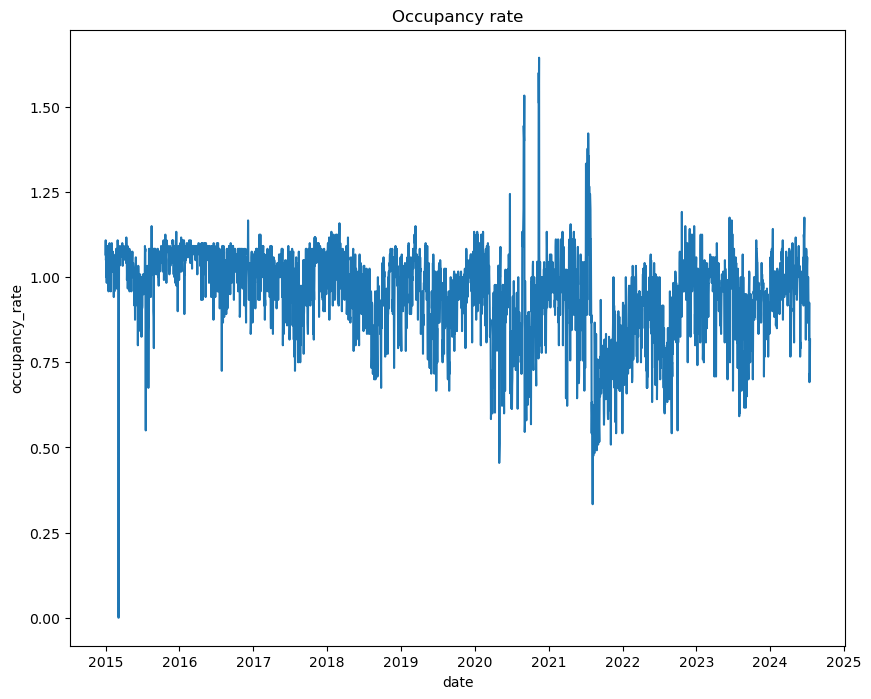

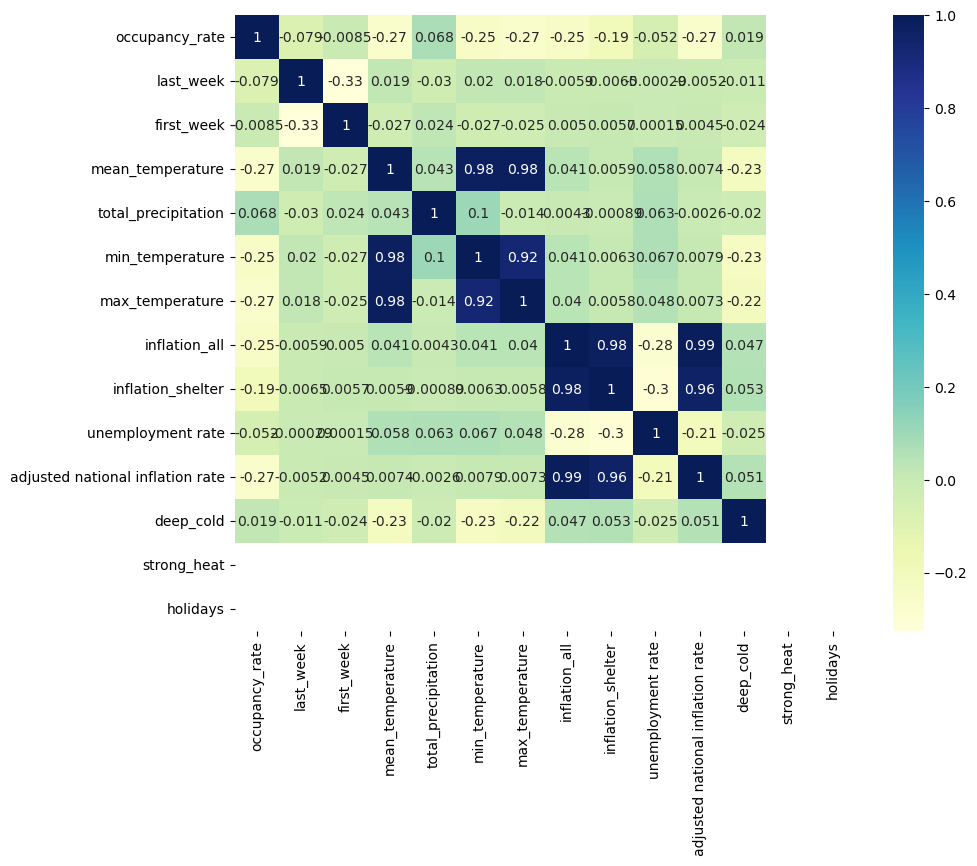

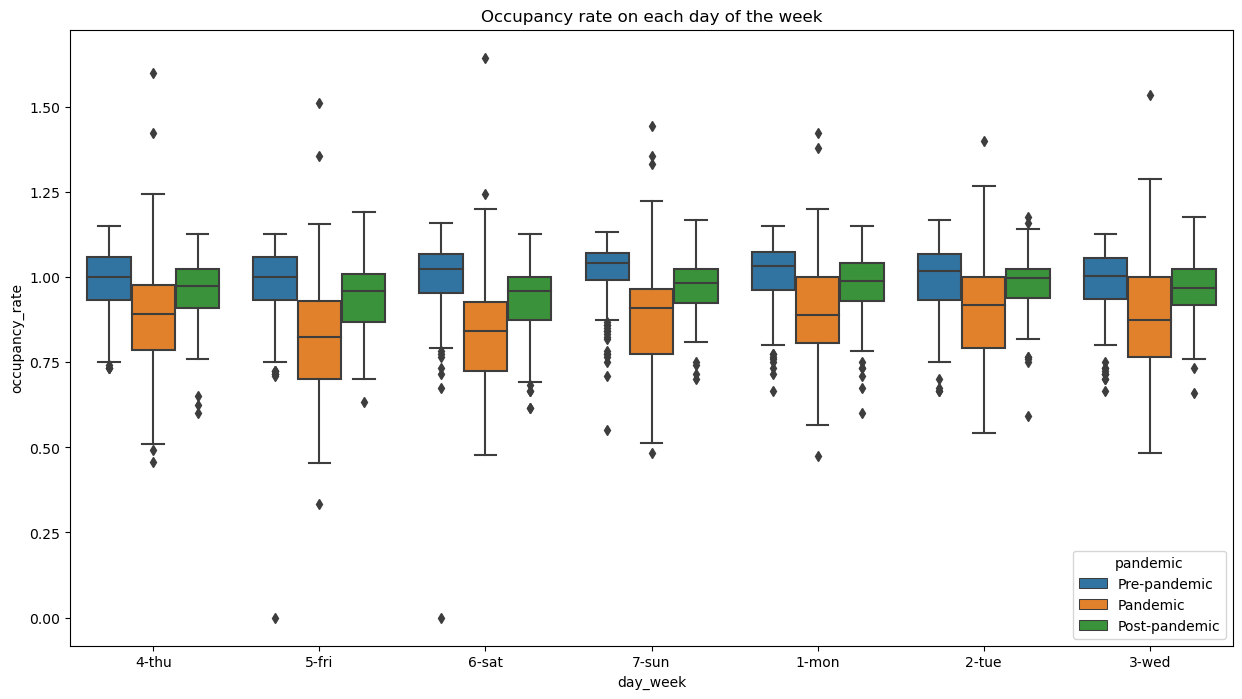

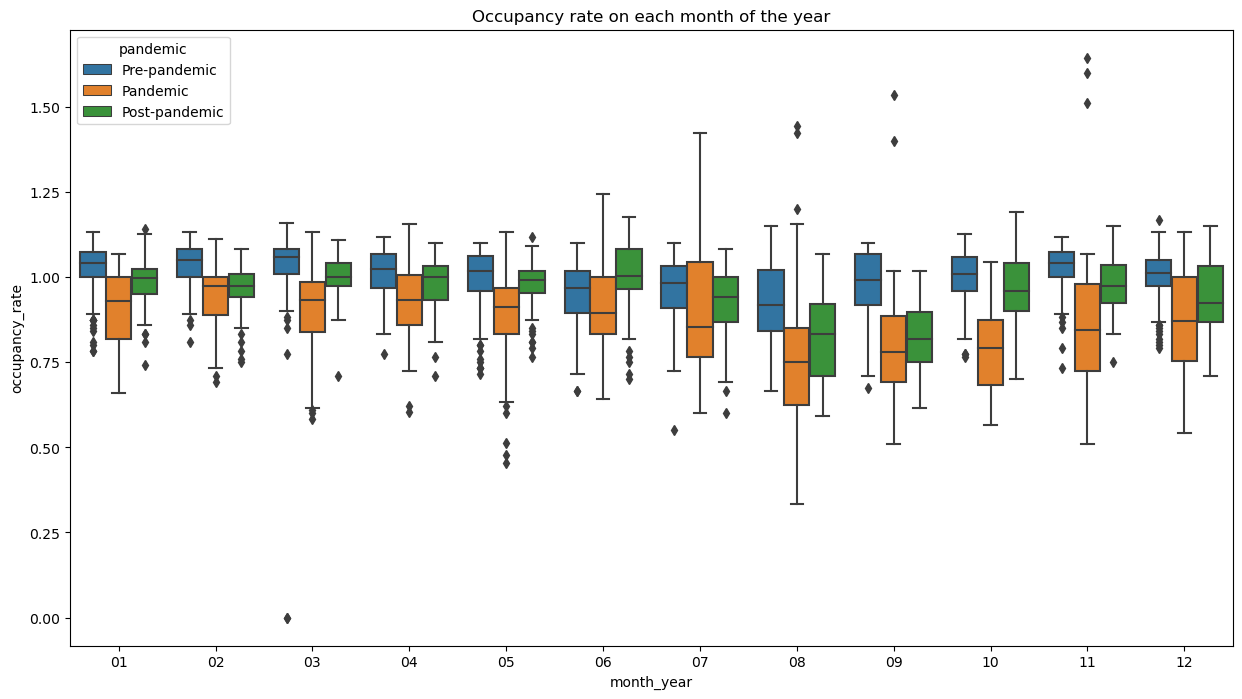

[0]	validation_0-rmse:0.45520	validation_1-rmse:0.47884
[100]	validation_0-rmse:0.18829	validation_1-rmse:0.20708
[200]	validation_0-rmse:0.10434	validation_1-rmse:0.11955


C:\Users\AShresth\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:12:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:0.08174	validation_1-rmse:0.09441
[400]	validation_0-rmse:0.07532	validation_1-rmse:0.08685
[500]	validation_0-rmse:0.07240	validation_1-rmse:0.08465
[600]	validation_0-rmse:0.07052	validation_1-rmse:0.08369
[700]	validation_0-rmse:0.06870	validation_1-rmse:0.08337
[800]	validation_0-rmse:0.06698	validation_1-rmse:0.08276
[900]	validation_0-rmse:0.06512	validation_1-rmse:0.08223
[999]	validation_0-rmse:0.06348	validation_1-rmse:0.08186


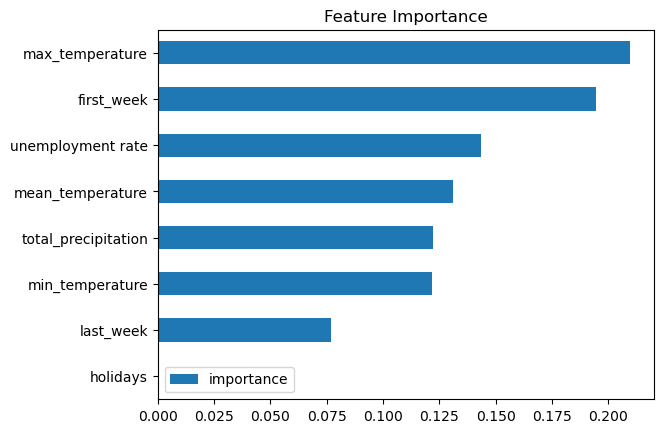

C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\3595195516.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


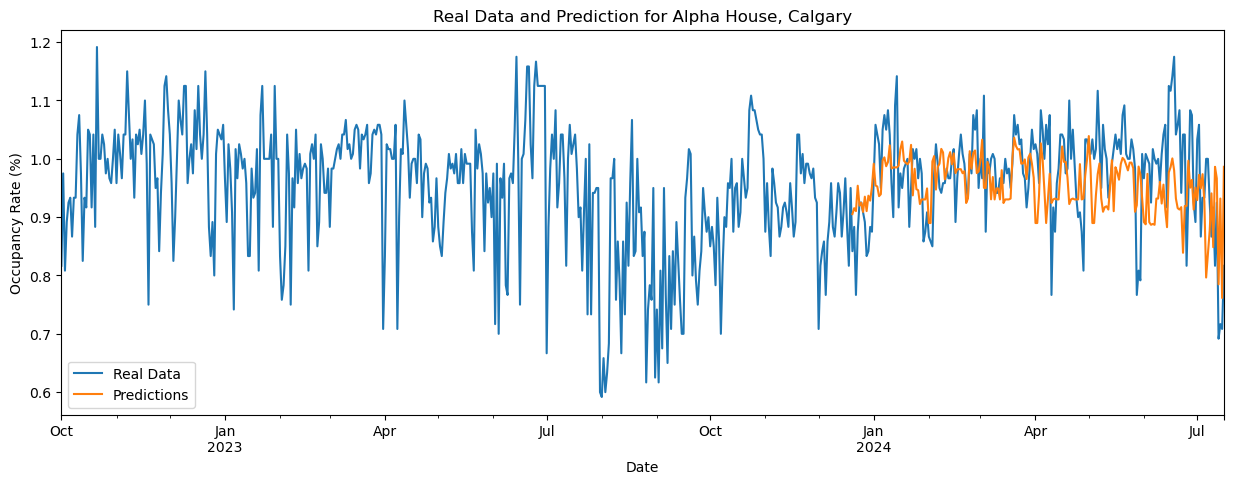

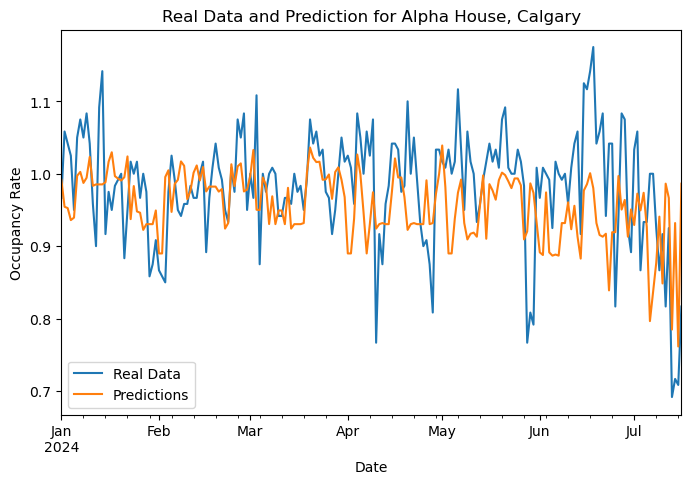

[0]	validation_0-rmse:0.45520	validation_1-rmse:0.47884
[100]	validation_0-rmse:0.18829	validation_1-rmse:0.20708
[200]	validation_0-rmse:0.10434	validation_1-rmse:0.11955
[300]	validation_0-rmse:0.08174	validation_1-rmse:0.09441


C:\Users\AShresth\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:12:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[400]	validation_0-rmse:0.07532	validation_1-rmse:0.08685
[500]	validation_0-rmse:0.07240	validation_1-rmse:0.08465
[600]	validation_0-rmse:0.07052	validation_1-rmse:0.08369
[700]	validation_0-rmse:0.06870	validation_1-rmse:0.08337
[800]	validation_0-rmse:0.06698	validation_1-rmse:0.08276
[900]	validation_0-rmse:0.06512	validation_1-rmse:0.08223
[999]	validation_0-rmse:0.06348	validation_1-rmse:0.08186
Score across folds 0.0819
Fold scores:[0.0818615228780031]


In [26]:
'''
Alberta Analysis One Shelter
'''
!pip install xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

df = df_orig
df['month_year'] = df['date'].dt.strftime('%m')

df['pandemic'] = "Pre-pandemic"
df.loc[(df['date'] >= '2020-03-11') & (df['date'] <= '2022-10-01'), 'pandemic'] = "Pandemic"
df.loc[(df['date'] > '2022-10-01'), 'pandemic'] = "Post-pandemic"
df["deep_cold"] = 0
df.loc[(df['min_temperature'] < -30), 'deep_cold'] = 1
df["strong_heat"] = 0
df.loc[(df['max_temperature'] > 38), 'strong_heat'] = 1

df = df.loc[df['ShelterName'] == 'Alpha House']

#Line Plot
fig, ax= plt.subplots(figsize = (10,8))
sns.lineplot(data=df, x="date", y="occupancy_rate")
ax.set_title("Occupancy rate")
plt.show()

#Heat map
df_heatmap = df
df_heatmap = df_heatmap[df_heatmap["pandemic"] == "Post-pandemic"]
df_heatmap = df[[ 'occupancy_rate', 'last_week', 'first_week', 'mean_temperature', 'total_precipitation', 'min_temperature',
       'max_temperature', 'inflation_all','inflation_shelter', 'unemployment rate','adjusted national inflation rate', 'deep_cold', 'strong_heat', 'holidays']]
plt.figure(figsize=(10,8))
ax.set_title('Correlation matrix post-pandemic')
sns.heatmap(df_heatmap.corr(), annot=True, cmap="YlGnBu")


#Box plots

fig, ax= plt.subplots(figsize = (15,8))
sns.boxplot(data=df, x="day_week", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy rate on each day of the week")
plt.show()

fig, ax= plt.subplots(figsize = (15,8))
sns.boxplot(data=df, x="month_year", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy rate on each month of the year")
plt.show()

#Split the data
df = df[df['date'] >= '2022-10-01']

df = df[df['occupancy_rate'].notna()]
df = df.set_index('date')

train = df.loc[df.index < '2023-12-20'] # Changed date from 2022-06-20 to 2023-06-20
test = df.loc[df.index >= '2023-12-20']

#Create model
FEATURES = [ 'last_week', 'first_week', 'mean_temperature', 'total_precipitation', 'min_temperature',
       'max_temperature', 'unemployment rate', 'holidays']
TARGET = "occupancy_rate"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#Perform the XGB Regression
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.show()

#Forecast on test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['occupancy_rate']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax)
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Real Data and Prediction for Alpha House, Calgary')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.show()

# Filter the data for dates after January 1, 2024
df_filtered = df[df.index >= '2024-01-01']

# Create the plot
ax = df_filtered[['occupancy_rate']].plot(figsize=(8, 5))
df_filtered['prediction'].plot(ax=ax)

# Customize the plot
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Real Data and Prediction for Alpha House, Calgary')
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.show()

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

fold = 0
preds = []
scores = []

y_pred = reg.predict(X_test)
preds.append(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')



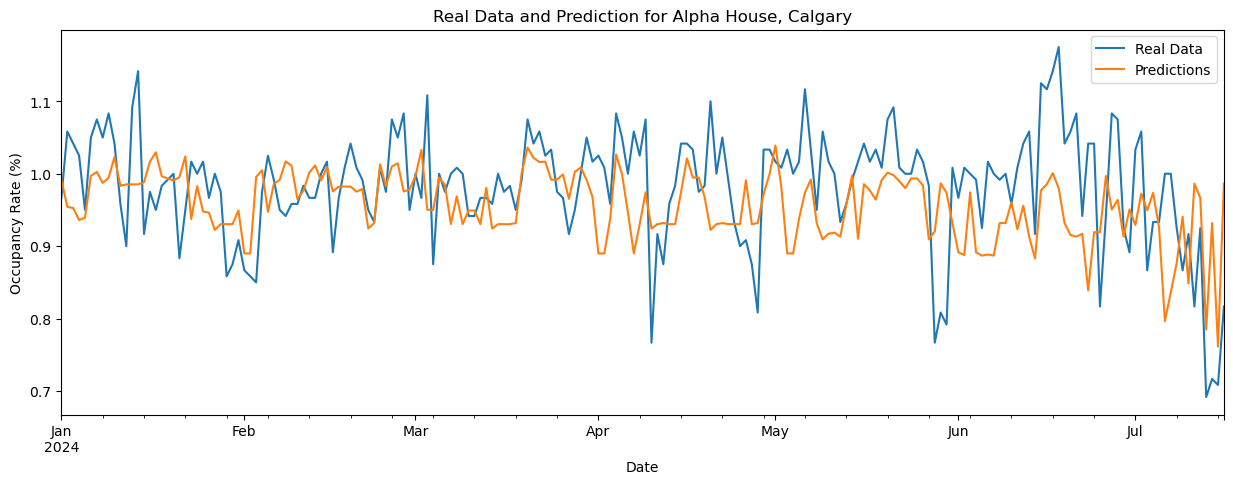

In [27]:
# prompt: plot occupancy rate and prediction on the same graph only after january 1, 2024

import matplotlib.pyplot as plt

# Filter the data for dates after January 1, 2024
df_filtered = df[df.index >= '2024-01-01']

# Create the plot
ax = df_filtered[['occupancy_rate']].plot(figsize=(15, 5))
df_filtered['prediction'].plot(ax=ax)

# Customize the plot
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Real Data and Prediction for Alpha House, Calgary')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.show()


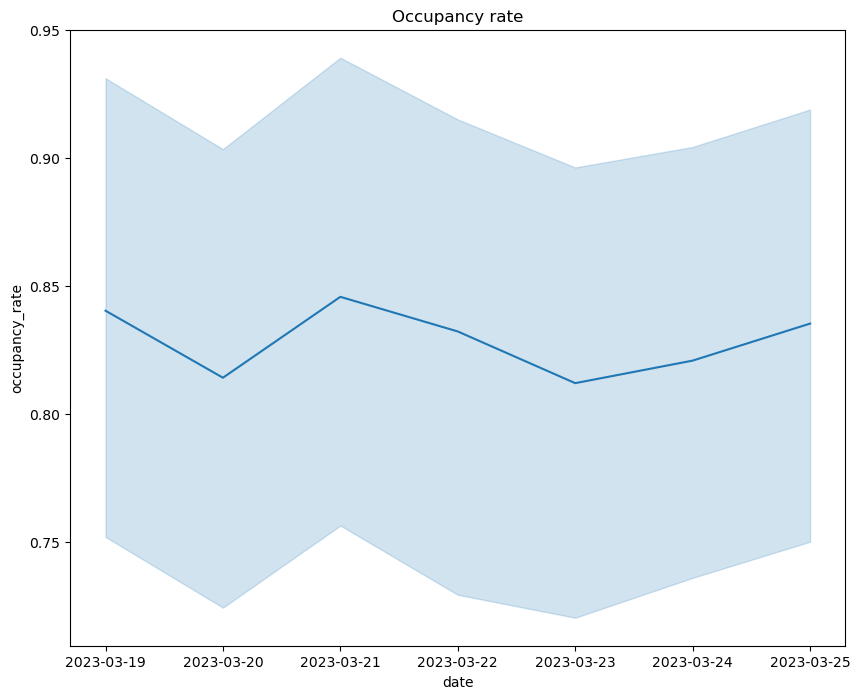

In [28]:
'''
Alberta Analysis One Shelter
'''

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

df = df_orig
df['month_year'] = df['date'].dt.strftime('%m')

df['pandemic'] = "Pre-pandemic"
df.loc[(df['date'] >= '2020-03-11') & (df['date'] <= '2022-10-01'), 'pandemic'] = "Pandemic"
df.loc[(df['date'] > '2022-10-01'), 'pandemic'] = "Post-pandemic"
df["deep_cold"] = 0
df.loc[(df['min_temperature'] < -30), 'deep_cold'] = 1
df["strong_heat"] = 0
df.loc[(df['max_temperature'] > 38), 'strong_heat'] = 1

df = df[df['date'] >= '2023-03-19']
df = df[df['date'] <= '2023-03-25']

df = df[df['occupancy_rate'].notna()]
df = df.set_index('date')

#df = df.loc[df['ShelterName'] == 'YW Calgary Emergency']

#Line Plot
fig, ax= plt.subplots(figsize = (10,8))
sns.lineplot(data=df, x="date", y="occupancy_rate")
ax.set_title("Occupancy rate")
plt.show()

df['avg_occupancy'] = df.groupby(['ShelterName'])['Capacity'].transform('mean')


In [29]:
import pandas as pd
if 'date' in df_orig.columns:
  df_orig['year'] = pd.to_datetime(df_orig['date']).dt.year
  df_filtered = df_orig[df_orig['year'] > 2022]
  average_capacity = df_filtered.groupby('ShelterName')['Capacity'].mean().sort_values().head(50)
  print(average_capacity)
else:
  print("No 'date' column found in the DataFrame.")

ShelterName
Reflections Society for Empowering People to Succeed                 5.000000
Reflections Society for Empowering People to Succeed - Wildfire      5.000000
Wapiti House - Women's Intox                                        10.000000
Wapiti House - Winter                                               10.000000
Mustard Seed Red Deer - Female only                                 11.000000
Slave Lake Homeless Coalition Shelter                               12.000000
Lakeland Out of the Elements                                        12.273535
Veterans - Short Term Supportive                                    15.000000
Elder's Caring Shelter - Short Term Supportive                      18.000000
Wagner Centre                                                       18.000000
Sagitawa Friendship Centre - Out of the Cold Shelter                20.000000
John Howard Society                                                 20.000000
Navigation & Support Centre                         

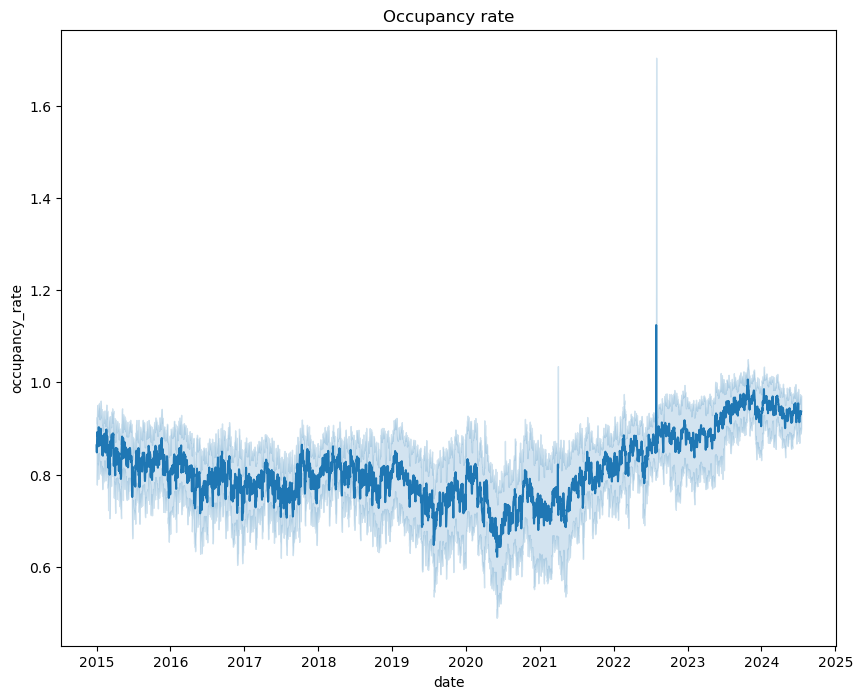

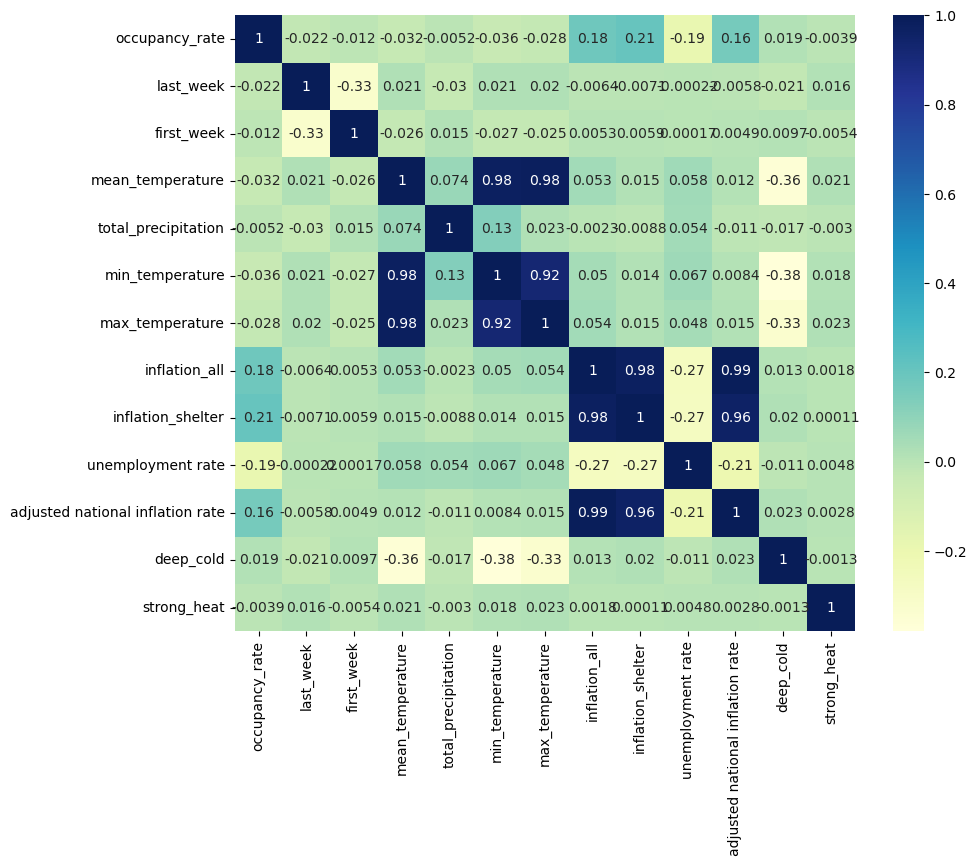

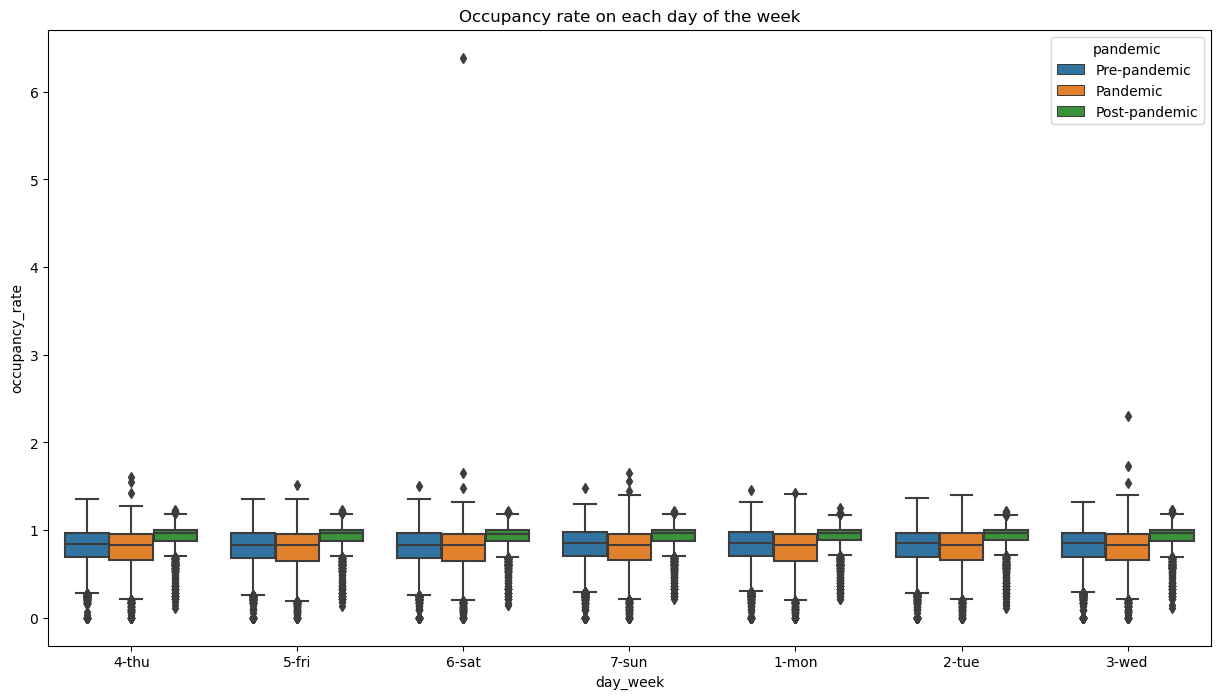

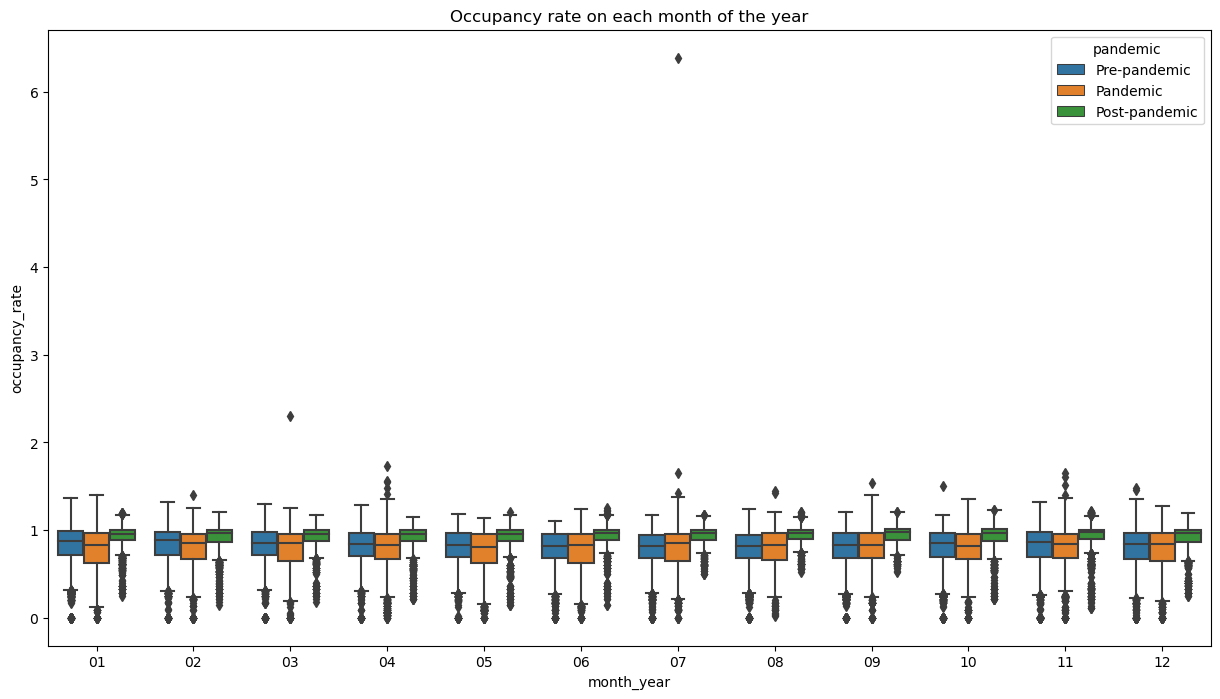

[0]	validation_0-rmse:0.42719	validation_1-rmse:0.45846
[100]	validation_0-rmse:0.23595	validation_1-rmse:0.24492
[200]	validation_0-rmse:0.19549	validation_1-rmse:0.19357


C:\Users\AShresth\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:16:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:0.18875	validation_1-rmse:0.17664
[400]	validation_0-rmse:0.18711	validation_1-rmse:0.17413
[460]	validation_0-rmse:0.18656	validation_1-rmse:0.17436


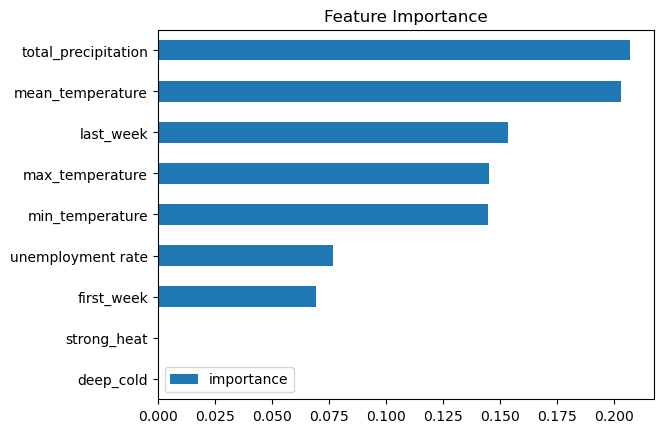

C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\3839048386.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


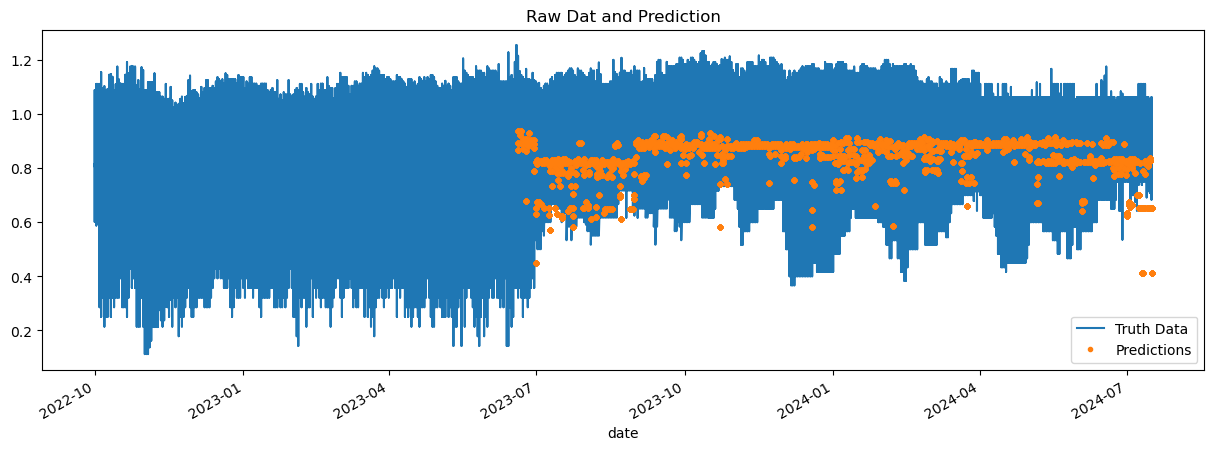

In [30]:
'''
Alberta Analysis Every Shelter
'''

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

df = df_orig
df['month_year'] = df['date'].dt.strftime('%m')

df['pandemic'] = "Pre-pandemic"
df.loc[(df['date'] >= '2020-03-11') & (df['date'] <= '2022-10-01'), 'pandemic'] = "Pandemic"
df.loc[(df['date'] > '2022-10-01'), 'pandemic'] = "Post-pandemic"
df["deep_cold"] = 0
df.loc[(df['min_temperature'] < -30), 'deep_cold'] = 1
df["strong_heat"] = 0
df.loc[(df['max_temperature'] > 38), 'strong_heat'] = 1

#keep only shelters represented during every week
df['ShelterName_count'] = df.groupby('ShelterName')['ShelterName'].transform('count')
df = df[df['ShelterName_count'] > 3300]

#Line Plot
fig, ax= plt.subplots(figsize = (10,8))
sns.lineplot(data=df, x="date", y="occupancy_rate")
ax.set_title("Occupancy rate")
plt.show()

#Heat map
df_heatmap = df
df_heatmap = df_heatmap[df_heatmap["pandemic"] == "Post-pandemic"]
df_heatmap = df[[ 'occupancy_rate', 'last_week', 'first_week', 'mean_temperature', 'total_precipitation', 'min_temperature',
       'max_temperature', 'inflation_all','inflation_shelter', 'unemployment rate','adjusted national inflation rate', 'deep_cold', 'strong_heat']]
plt.figure(figsize=(10,8))
ax.set_title('Correlation matrix post-pandemic')
sns.heatmap(df_heatmap.corr(), annot=True, cmap="YlGnBu")

#Box plots
fig, ax= plt.subplots(figsize = (15,8))
sns.boxplot(data=df, x="day_week", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy rate on each day of the week")
plt.show()

fig, ax= plt.subplots(figsize = (15,8))
sns.boxplot(data=df, x="month_year", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy rate on each month of the year")
plt.show()

#Split the data
df = df[df['date'] >= '2022-10-01']

df = df[df['occupancy_rate'].notna()]
df = df.set_index('date')

train = df.loc[df.index < '2023-06-20'] # Changed date from 2022-06-20 to 2023-06-20
test = df.loc[df.index >= '2023-06-20']

#Create model
FEATURES = [ 'last_week', 'first_week', 'mean_temperature', 'total_precipitation', 'min_temperature',
       'max_temperature', 'unemployment rate', 'deep_cold', 'strong_heat']
TARGET = "occupancy_rate"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#Perform the XGB Regression
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.show()

#Forecast on test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['occupancy_rate']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


In [31]:
#analyze Toronto data

import pandas as pd
import os
import holidays

# Get the Downloads folder path
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")

# Define the path to the Toronto CSV file in Downloads
input_file = os.path.join(downloads_path, "output_toronto.csv")

# Load the Toronto data into a DataFrame
df_orig = pd.read_csv(input_file)

# Display the DataFrame
df_orig

C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\173875691.py:14: DtypeWarning: Columns (1,2,3,4,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv(input_file)


,date,city_x,ShelterType,ShelterName,Organization,Capacity,Overnight,year,month,unoccupied,...,min_temperature,max_temperature,province,x,y,CMA,inflation_all,inflation_shelter,unemployment rate,adjusted national inflation rate
0,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,29.0,26.0,2021.0,2021-01,3.0,...,-0.5,5.5,AB,-115.066667,51.083333,Toronto,141.0,152.3,11.3,186.8
1,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,29.0,26.0,2021.0,2021-01,3.0,...,-6.0,3.4,AB,-114.013333,51.122500,Toronto,141.0,152.3,11.3,186.8
2,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,29.0,26.0,2021.0,2021-01,3.0,...,-12.1,-6.0,AB,-110.283333,54.416667,Toronto,141.0,152.3,11.3,186.8
3,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,29.0,26.0,2021.0,2021-01,3.0,...,-13.4,-4.0,AB,-113.605836,53.306667,Toronto,141.0,152.3,11.3,186.8
4,2021-01-01,North York,Motel/Hotel Shelter,COSTI/City North York West Hotel Program,COSTI Immigrant Services,29.0,26.0,2021.0,2021-01,3.0,...,-15.9,-4.9,AB,-116.465000,53.578889,Toronto,141.0,152.3,11.3,186.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868328,2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12,NaN,...,-2.5,4.1,ON,-79.396111,43.627500,Toronto,140.5,153.1,9.1,186.5
2868329,2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12,NaN,...,-1.7,5.1,ON,-79.396111,43.627500,Toronto,140.5,153.1,9.1,186.5
2868330,2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12,NaN,...,-4.0,-0.1,ON,-79.396111,43.627500,Toronto,140.5,153.1,9.1,186.5
2868331,2020-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12,NaN,...,-2.8,5.1,ON,-79.396111,43.627500,Toronto,140.5,153.1,9.1,186.5


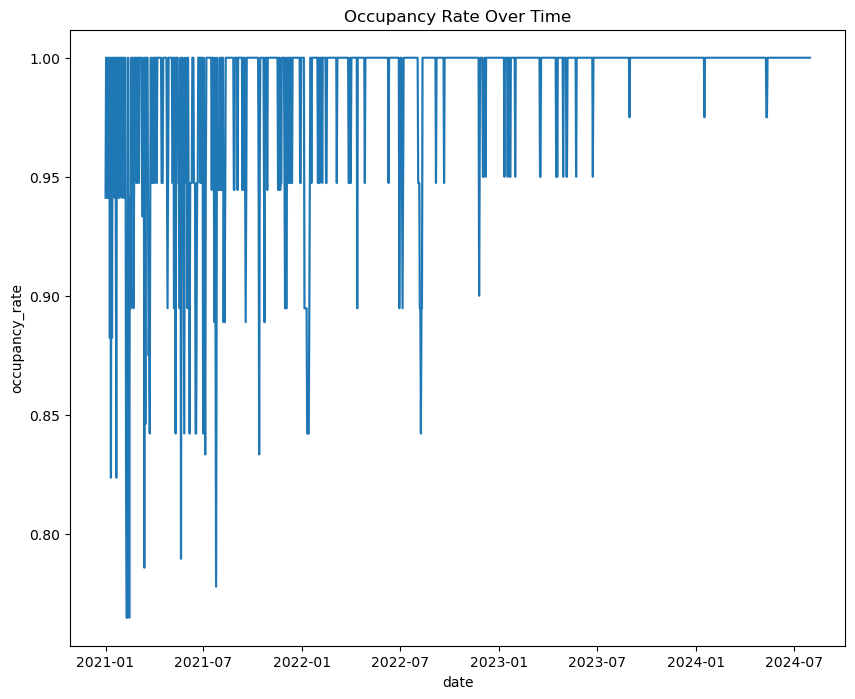

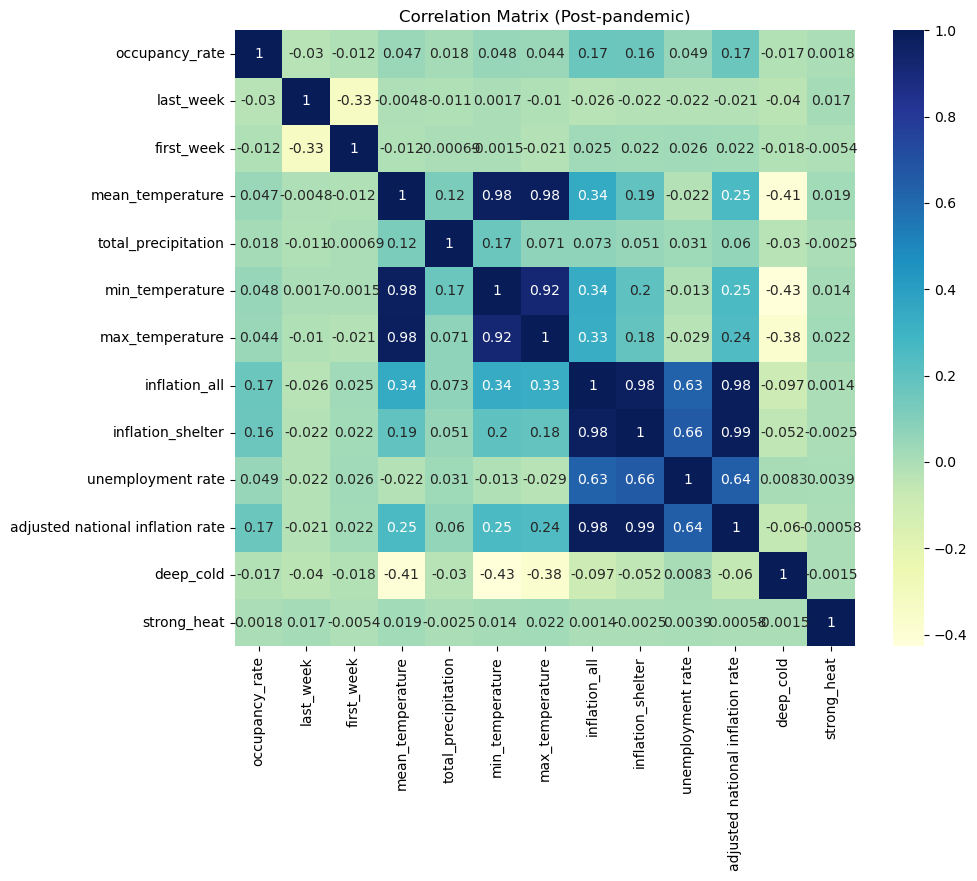

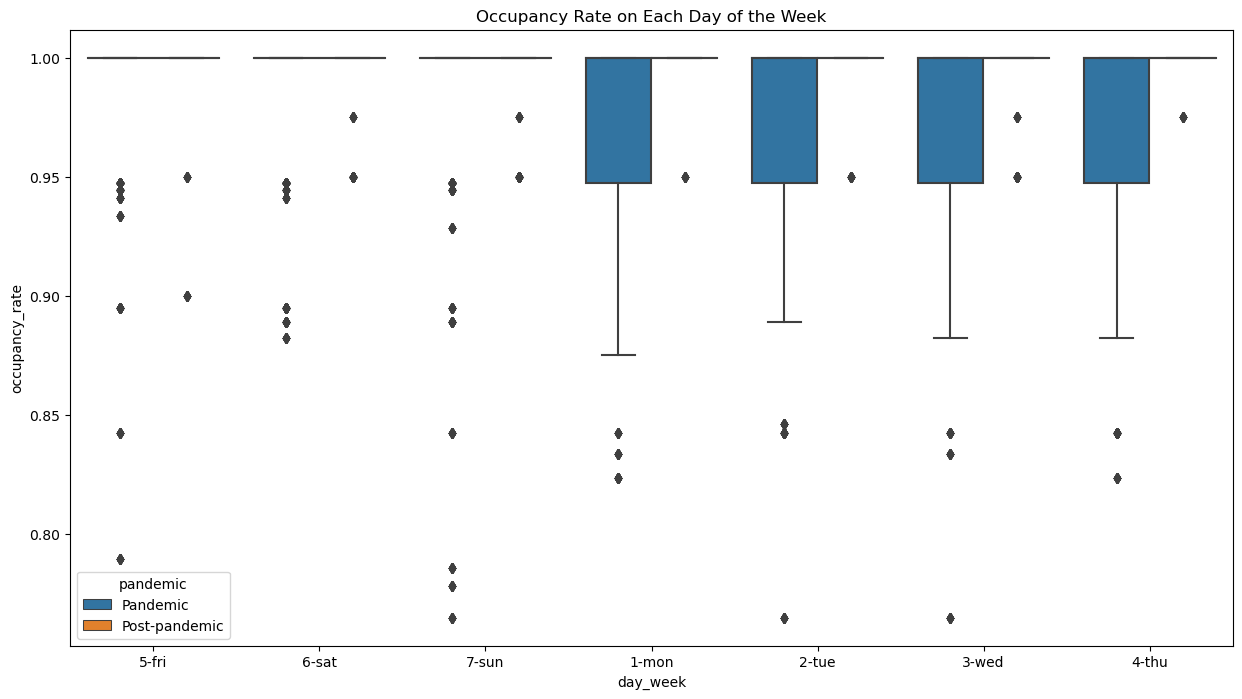

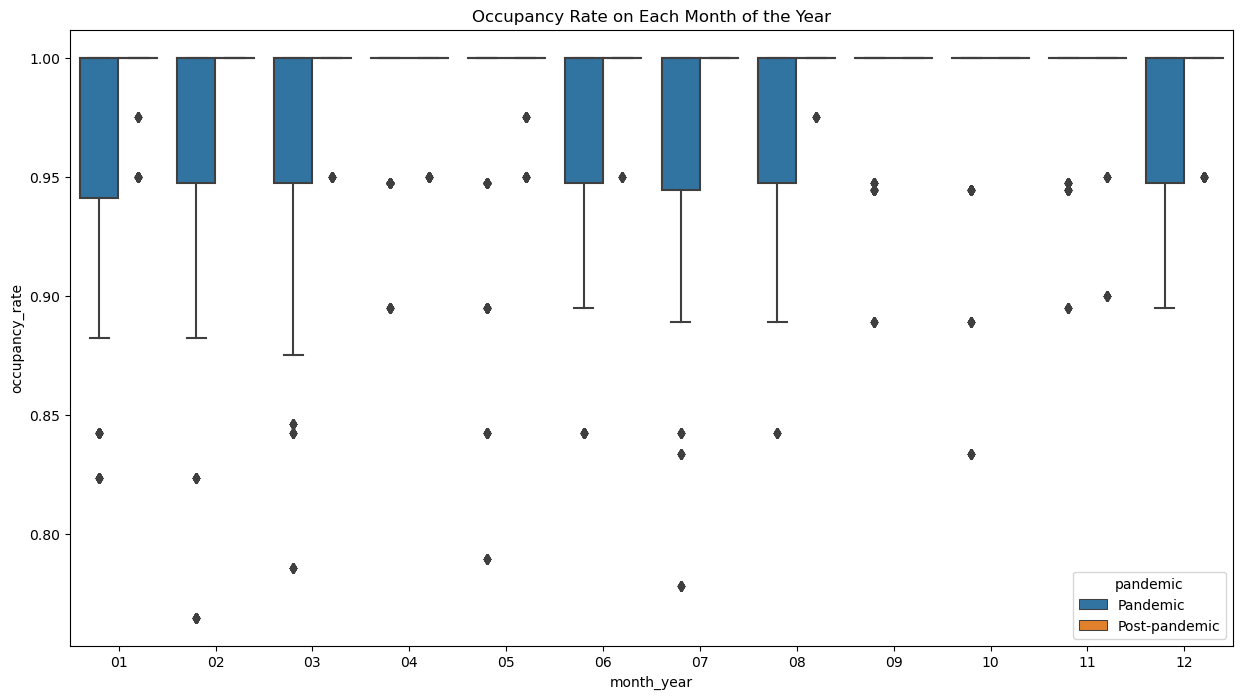

[0]	validation_0-rmse:0.49141	validation_1-rmse:0.49467
[100]	validation_0-rmse:0.18039	validation_1-rmse:0.18333
[200]	validation_0-rmse:0.06730	validation_1-rmse:0.07019
[300]	validation_0-rmse:0.02763	validation_1-rmse:0.03043
[400]	validation_0-rmse:0.01579	validation_1-rmse:0.01679
[500]	validation_0-rmse:0.01327	validation_1-rmse:0.01213
[600]	validation_0-rmse:0.01278	validation_1-rmse:0.01071
[700]	validation_0-rmse:0.01260	validation_1-rmse:0.01015
[800]	validation_0-rmse:0.01245	validation_1-rmse:0.00976
[900]	validation_0-rmse:0.01229	validation_1-rmse:0.00964
[916]	validation_0-rmse:0.01227	validation_1-rmse:0.00966


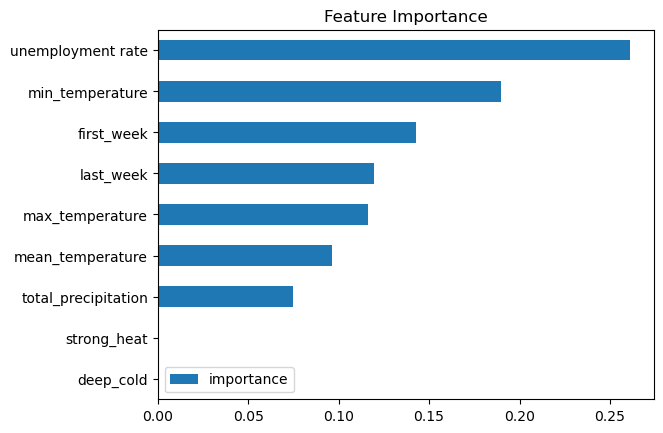

C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\3725893900.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


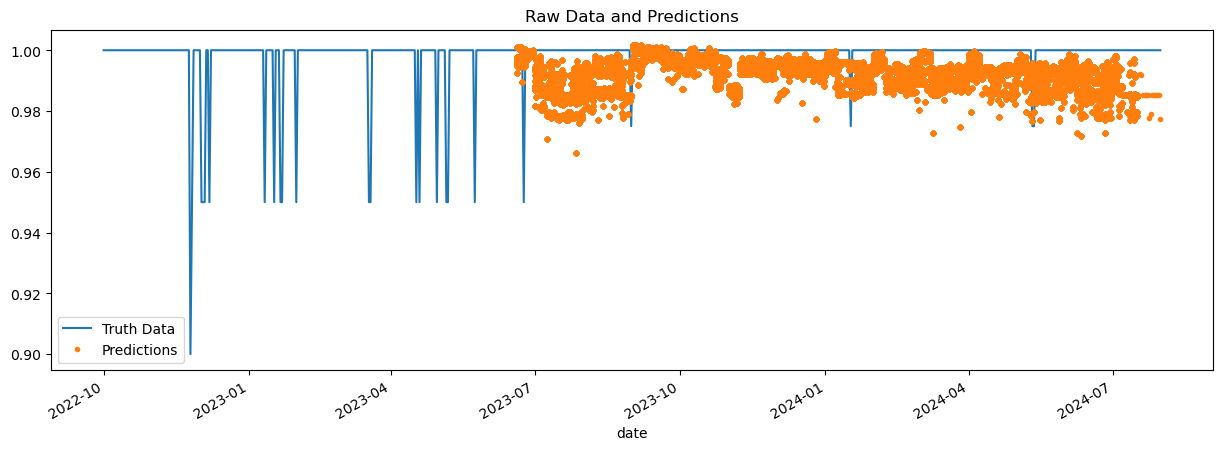

In [32]:
'''
Toronto Analysis One Shelter
'''

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Ensure the DataFrame is properly loaded
df = df_orig.copy()

# Fix: Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Fix: Ensure month-year extraction works
df['month_year'] = df['date'].dt.strftime('%m')

# Fix: Handle missing values in 'date' before using .loc
df['pandemic'] = "Pre-pandemic"
df.loc[(df['date'] >= '2020-03-11') & (df['date'] <= '2022-10-01'), 'pandemic'] = "Pandemic"
df.loc[(df['date'] > '2022-10-01'), 'pandemic'] = "Post-pandemic"

df["deep_cold"] = 0
df.loc[df['min_temperature'] < -30, 'deep_cold'] = 1

df["strong_heat"] = 0
df.loc[df['max_temperature'] > 38, 'strong_heat'] = 1

# Fix: Ensure the shelter exists in data
df = df[df['ShelterName'] == "Vanauley Street YMCA Emergency Shelter"]

# Line Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x="date", y="occupancy_rate")
ax.set_title("Occupancy Rate Over Time")
plt.show()

# Heat Map (Only for Post-pandemic period)
df_heatmap = df[df["pandemic"] == "Post-pandemic"]

# Select relevant numerical columns for correlation analysis
heatmap_columns = [
    'occupancy_rate', 'last_week', 'first_week', 'mean_temperature', 
    'total_precipitation', 'min_temperature', 'max_temperature', 
    'inflation_all', 'inflation_shelter', 'unemployment rate',
    'adjusted national inflation rate', 'deep_cold', 'strong_heat'
]

df_heatmap = df_heatmap[heatmap_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap.corr(), annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix (Post-pandemic)')
plt.show()

# Box plots
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x="day_week", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy Rate on Each Day of the Week")
plt.show()

fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x="month_year", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy Rate on Each Month of the Year")
plt.show()

# Split the data for training and testing
df = df[df['date'] >= '2022-10-01']
df = df[df['occupancy_rate'].notna()]
df = df.set_index('date')

train = df.loc[df.index < '2023-06-20']
test = df.loc[df.index >= '2023-06-20']

# Define Features & Target
FEATURES = [
    'last_week', 'first_week', 'mean_temperature', 'total_precipitation', 
    'min_temperature', 'max_temperature', 'unemployment rate', 
    'deep_cold', 'strong_heat'
]
TARGET = "occupancy_rate"

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

# XGBoost Regression Model (Fix deprecated 'reg:linear' -> 'reg:squarederror')
reg = xgb.XGBRegressor(
    base_score=0.5, booster='gbtree', n_estimators=1000,
    early_stopping_rounds=50, objective='reg:squarederror',
    max_depth=3, learning_rate=0.01
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Feature Importance Plot
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on test data
test['prediction'] = reg.predict(X_test)

# Merge predictions
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot True vs Predicted Values
ax = df[['occupancy_rate']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()


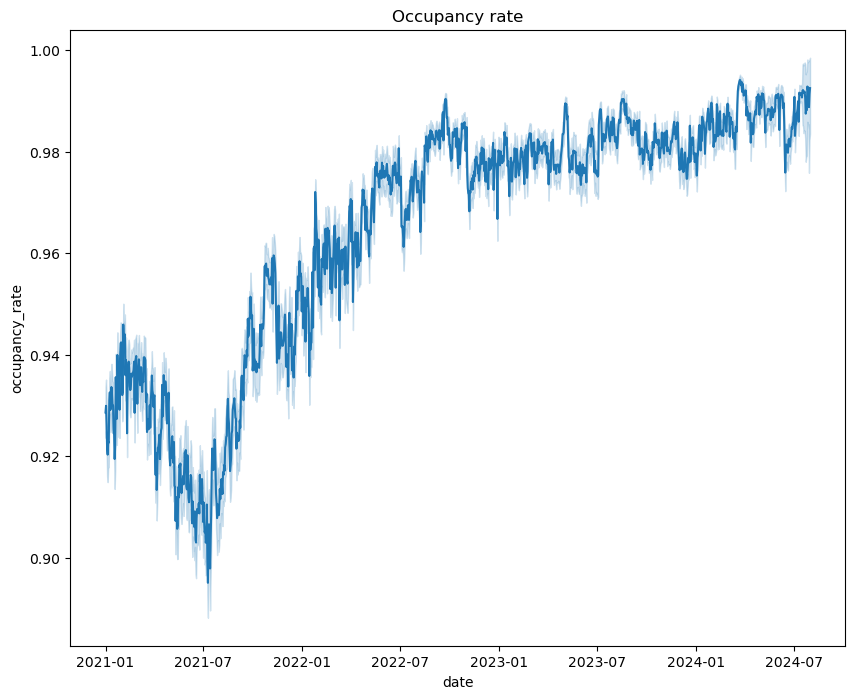

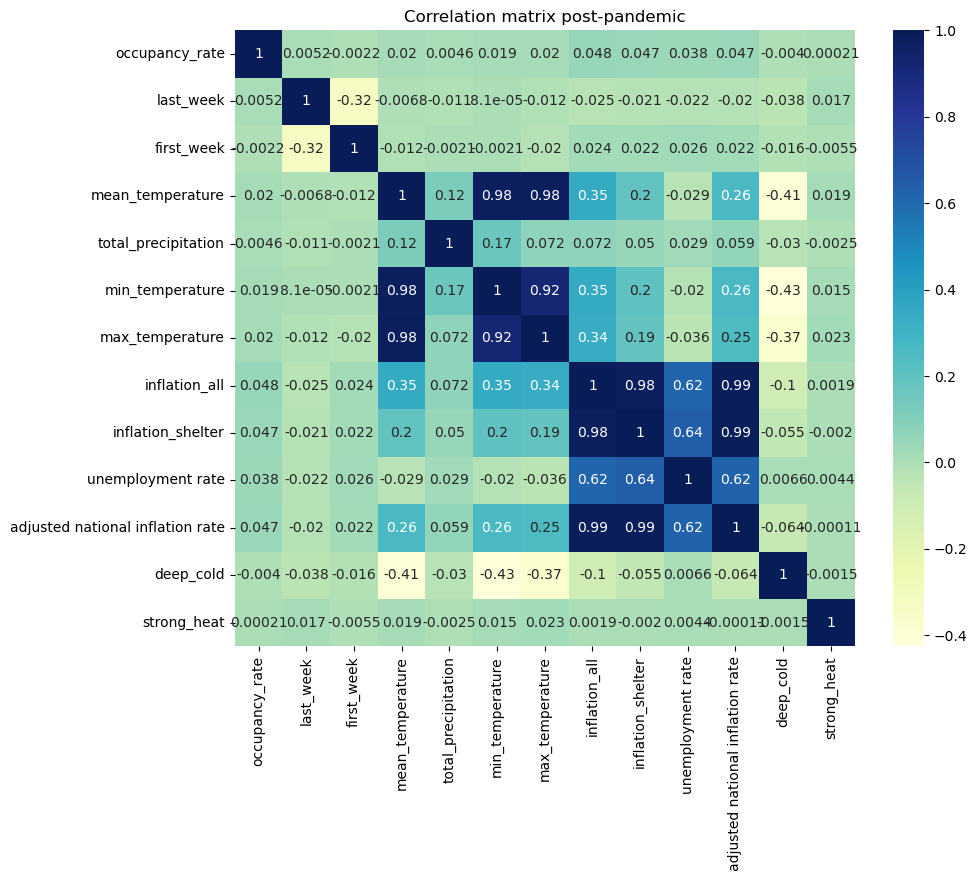

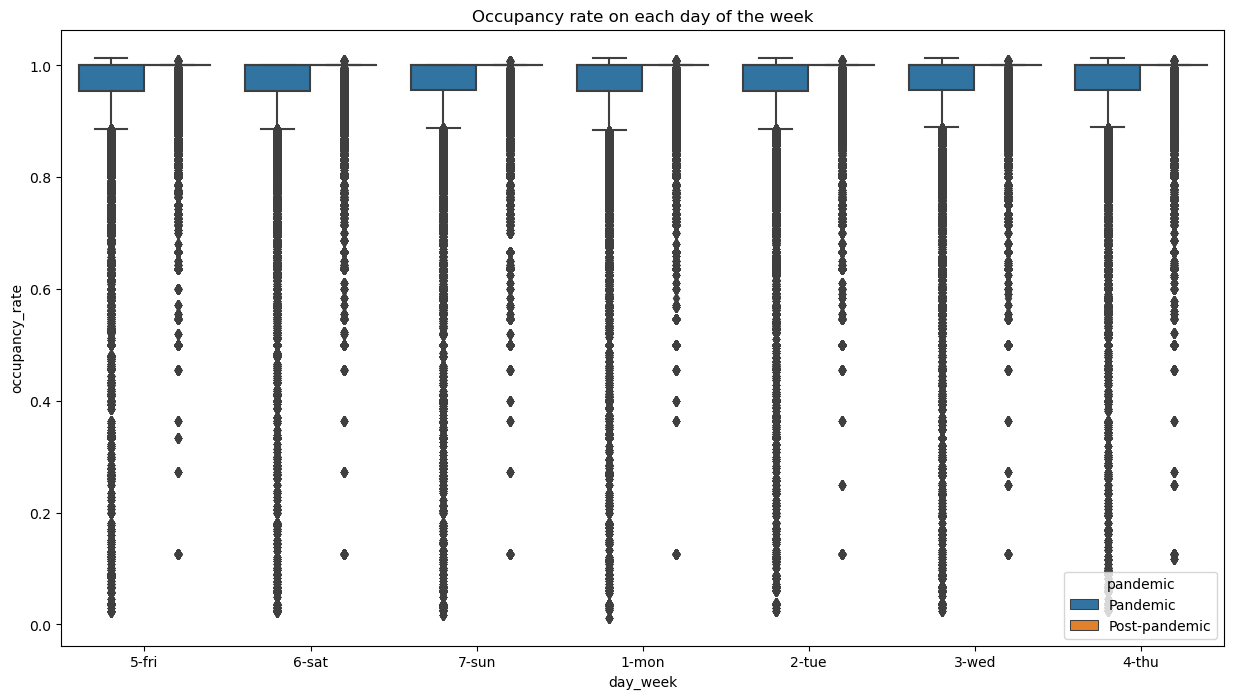

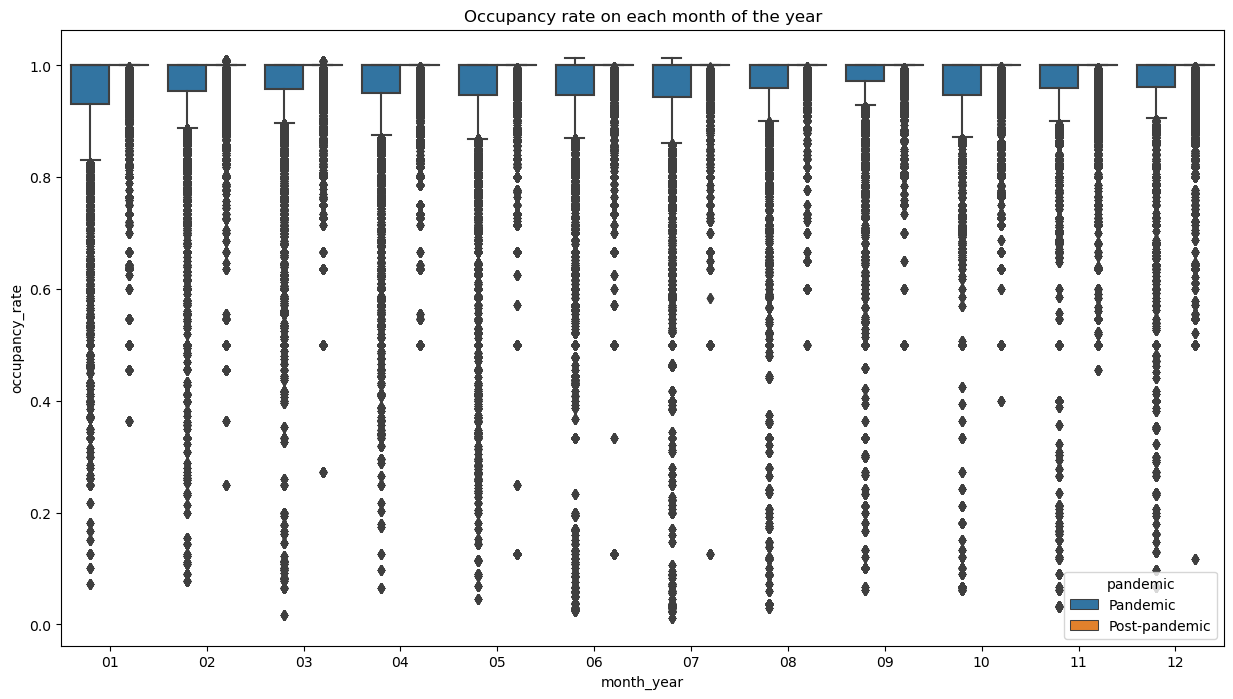

[0]	validation_0-rmse:0.47916	validation_1-rmse:0.48288
[100]	validation_0-rmse:0.18695	validation_1-rmse:0.18759
[200]	validation_0-rmse:0.09419	validation_1-rmse:0.08901
[300]	validation_0-rmse:0.07333	validation_1-rmse:0.06314
[400]	validation_0-rmse:0.07006	validation_1-rmse:0.05790
[500]	validation_0-rmse:0.06961	validation_1-rmse:0.05681
[600]	validation_0-rmse:0.06954	validation_1-rmse:0.05654
[700]	validation_0-rmse:0.06953	validation_1-rmse:0.05646
[800]	validation_0-rmse:0.06953	validation_1-rmse:0.05643
[900]	validation_0-rmse:0.06953	validation_1-rmse:0.05643
[999]	validation_0-rmse:0.06953	validation_1-rmse:0.05641


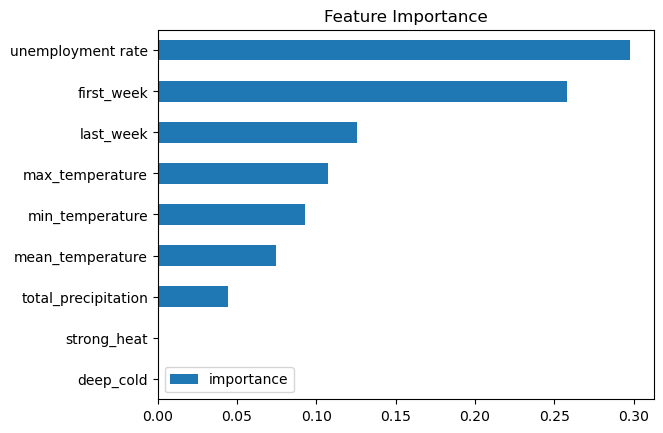

C:\Users\AShresth\AppData\Local\Temp\ipykernel_25084\802502448.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


MemoryError: Unable to allocate 11.2 GiB for an array with shape (1503589845,) and data type datetime64[ns]

In [33]:
'''
Toronto Analysis Every Shelter
'''

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Ensure df_orig is a valid DataFrame
df = df_orig.copy()

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create 'month_year' column
df['month_year'] = df['date'].dt.strftime('%m')

# Define pandemic periods
df['pandemic'] = "Pre-pandemic"
df.loc[(df['date'] >= '2020-03-11') & (df['date'] <= '2022-10-01'), 'pandemic'] = "Pandemic"
df.loc[(df['date'] > '2022-10-01'), 'pandemic'] = "Post-pandemic"

# Define extreme temperature indicators
df["deep_cold"] = (df['min_temperature'] < -30).astype(int)
df["strong_heat"] = (df['max_temperature'] > 38).astype(int)

# Keep only shelters represented every week
df['ShelterName_count'] = df.groupby('ShelterName')['ShelterName'].transform('count')
df = df[df['ShelterName_count'] > 3300]

# Line Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x="date", y="occupancy_rate")
ax.set_title("Occupancy rate")
plt.show()

# Heatmap
df_heatmap = df[df["pandemic"] == "Post-pandemic"]
df_heatmap = df_heatmap[['occupancy_rate', 'last_week', 'first_week', 'mean_temperature', 'total_precipitation', 
                         'min_temperature', 'max_temperature', 'inflation_all', 'inflation_shelter', 
                         'unemployment rate', 'adjusted national inflation rate', 'deep_cold', 'strong_heat']]
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap.corr(), annot=True, cmap="YlGnBu")
plt.title('Correlation matrix post-pandemic')
plt.show()

# Box plots
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x="day_week", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy rate on each day of the week")
plt.show()

fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x="month_year", y="occupancy_rate", hue="pandemic")
ax.set_title("Occupancy rate on each month of the year")
plt.show()

# Filter data for post-pandemic
df = df[df['date'] >= '2022-10-01']

# Remove NaN occupancy_rate
df = df[df['occupancy_rate'].notna()]
df = df.set_index('date')

# Train-test split
train = df.loc[df.index < '2023-06-20']
test = df.loc[df.index >= '2023-06-20']

# Define features and target
FEATURES = ['last_week', 'first_week', 'mean_temperature', 'total_precipitation', 'min_temperature',
            'max_temperature', 'unemployment rate', 'deep_cold', 'strong_heat']
TARGET = "occupancy_rate"

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

# XGBoost Model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000, early_stopping_rounds=50,
                       objective='reg:squarederror', max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Feature Importance Plot
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Predictions
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot actual vs predicted
ax = df[['occupancy_rate']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()


